In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#normalize
def normalize(df):
    norm = df.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
    return norm
#scale back to the true range
def true_range(df, x):
    X = (x * (df['mid1'].max() - df['mid1'].min())) + df['mid1'].min()
    return X
#rolling windows
def train_windows(df, ref_day=10, predict_day=5):
    X_train, Y_train = [], []
    for i in range(int(df.shape[0] / 5 - 2)):
        #扣掉response
        #記得最後一行要放response
        #if i == df.shape[0]-predict_day-ref_day -1:
        #    X_train.append(np.array(df.iloc[i:i+ref_day,:-1]))
        #    Y_train.append(np.array(df.iloc[i+ref_day:]["mid1"]))
        #else:  
        X_train.append(np.array(df.iloc[i * predict_day: predict_day * (i + 2),:-1]))
        Y_train.append(np.array(df.iloc[(i+2) * predict_day: (i+3) * predict_day]["mid1"]))
    return np.array(X_train), np.array(Y_train)
#LSTM (when add the drop out layer in order to deal with overfitting)
def lstm_stock_model(shape):
    model = Sequential()
    #return sequence = True -> means the network will have long memory
    model.add(LSTM(256, input_shape=(shape[1], shape[2]), return_sequences=True))
    model.add(LSTM(256, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(1)))
    model.add(Flatten())
    #10 -> X shape
    model.add(Dense(10,activation='linear'))
    #5 -> Y shape
    model.add(Dense(5,activation='linear'))
    model.compile(loss="mean_squared_error", optimizer="adam",metrics=['mean_squared_error'])
    model.summary()
    return model

#record transaction
def record_transaction(para, date, tick, action_side, price, equity_value, transaction_history):
    info = {
                'Date': date,
                'tick': tick,
                'Action': action_side,
                'Price': price,
                'Equity_value': equity_value
            }
    if para in transaction_history:
        transaction_history[para].append(info)
    else:
        transaction_history.update({para: [info]})    
    
    return transaction_history

#performance
def performance(equity_value_, transaction):
    #return
    Return = equity_value_.iloc[-1][0]
    print('return:', Return)
    #vol
    Std = equity_value_.std()[0]
    print('std:', Std)
    #sharp ratio
    Sharp_ratio = (Return - 0.0052) / Std
    print('sharp ratio:', Sharp_ratio)
    #nums of trading
    Trades = len(transaction) / 2
    print('trades:', Trades)
    #odds ratio
    R = 0
    for i in range(len(transaction)):
        if transaction[i]['Equity_value'] > 0:
            R += 1
    Odd = R / (len(transaction) / 2)
    print('odds ratio:', Odd)
    #mdd
    Mdd = (equity_value_.cummax() - equity_value_).max()[0]
    print('mdd:', Mdd)
    #skew
    Skew = equity_value_.skew()[0]
    print('skewness:', Skew)
     
    return Return, Std, Sharp_ratio, Trades, Odd, Mdd, Skew

#model performance
def model_performance(y, f):
    tot = np.sum(np.square(y - np.mean(y)))
    res = np.sum(np.square(y - f))
    r_squared = 1 - res / tot
    mse = np.mean(np.square(y - f)) * (1 / len(y))
    print('MSE:', mse)
    print('r-squared:', r_squared)

In [3]:
df = pd.read_csv('./data/3406_2.csv')
df['spread1'] = df['Ask1'] - df['Bid1']
df['spread2'] = df['Ask2'] - df['Bid2']
df['spread3'] = df['Ask3'] - df['Bid3']
df['spread4'] = df['Ask4'] - df['Bid4']
df['spread5'] = df['Ask5'] - df['Bid5']
df['mid2'] = (df['Ask2'] + df['Bid2']) / 2
df['mid3'] = (df['Ask3'] + df['Bid3']) / 2
df['mid4'] = (df['Ask4'] + df['Bid4']) / 2
df['mid5'] = (df['Ask5'] + df['Bid5']) / 2
df['a51_diff'] = df['Ask5'] - df['Ask1']
df['b15_diff'] = df['Bid1'] - df['Bid5']
df['a21_diff_abs'] = np.abs(df['Ask2'] - df['Ask1'])
df['a32_diff_abs'] = np.abs(df['Ask3'] - df['Ask2'])
df['a43_diff_abs'] = np.abs(df['Ask4'] - df['Ask3'])
df['a54_diff_abs'] = np.abs(df['Ask5'] - df['Ask4'])
df['b21_diff_abs'] = np.abs(df['Bid2'] - df['Bid1'])
df['b32_diff_abs'] = np.abs(df['Bid3'] - df['Bid2'])
df['b43_diff_abs'] = np.abs(df['Bid4'] - df['Bid3'])
df['b54_diff_abs'] = np.abs(df['Bid5'] - df['Bid4'])
df['a_mean'] = (df['Ask1'] +df['Ask2'] +df['Ask3'] +df['Ask4'] +df['Ask5']) / 5
df['b_mean'] = (df['Bid1'] +df['Bid2'] +df['Bid3'] +df['Bid4'] +df['Bid5']) / 5
df['aq_mean'] = (df['AskQty1'] +df['AskQty2'] +df['AskQty3'] +df['AskQty4'] +df['AskQty5']) / 5
df['bq_mean'] = (df['BidQty1'] +df['BidQty2'] +df['BidQty3'] +df['BidQty4'] +df['BidQty5']) / 5
df['p_acc_diff'] = (df['Ask1'] - df['Bid1']) +(df['Ask2'] - df['Bid2']) + (df['Ask3'] - df['Bid3']) + (df['Ask4'] - df['Bid4']) + (df['Ask5'] - df['Bid5'])
df['q_acc_diff'] = (df['AskQty1'] - df['BidQty1']) +(df['AskQty2'] - df['BidQty2']) + (df['AskQty3'] - df['BidQty3']) + (df['AskQty4'] - df['BidQty4']) + (df['AskQty5'] - df['BidQty5'])
#1 tick
df['da1_dt_1'] = df['Ask1'] - df['Ask1'].shift(1)
df['da2_dt_1'] = df['Ask2'] - df['Ask2'].shift(1)
df['da3_dt_1'] = df['Ask3'] - df['Ask3'].shift(1)
df['da4_dt_1'] = df['Ask4'] - df['Ask4'].shift(1)
df['da5_dt_1'] = df['Ask5'] - df['Ask5'].shift(1)
df['db1_dt_1'] = df['Bid1'] - df['Bid1'].shift(1)
df['db2_dt_1'] = df['Bid2'] - df['Bid2'].shift(1)
df['db3_dt_1'] = df['Bid3'] - df['Bid3'].shift(1)
df['db4_dt_1'] = df['Bid4'] - df['Bid4'].shift(1)
df['db5_dt_1'] = df['Bid5'] - df['Bid5'].shift(1)
#5 ticks
df['da1_dt_5'] = df['Ask1'] - df['Ask1'].shift(5)
df['da2_dt_5'] = df['Ask2'] - df['Ask2'].shift(5)
df['da3_dt_5'] = df['Ask3'] - df['Ask3'].shift(5)
df['da4_dt_5'] = df['Ask4'] - df['Ask4'].shift(5)
df['da5_dt_5'] = df['Ask5'] - df['Ask5'].shift(5)
df['db1_dt_5'] = df['Bid1'] - df['Bid1'].shift(5)
df['db2_dt_5'] = df['Bid2'] - df['Bid2'].shift(5)
df['db3_dt_5'] = df['Bid3'] - df['Bid3'].shift(5)
df['db4_dt_5'] = df['Bid4'] - df['Bid4'].shift(5)
df['db5_dt_5'] = df['Bid5'] - df['Bid5'].shift(5)
##10 ticks
df['da1_dt_10'] = df['Ask1'] - df['Ask1'].shift(10)
df['da2_dt_10'] = df['Ask2'] - df['Ask2'].shift(10)
df['da3_dt_10'] = df['Ask3'] - df['Ask3'].shift(10)
df['da4_dt_10'] = df['Ask4'] - df['Ask4'].shift(10)
df['da5_dt_10'] = df['Ask5'] - df['Ask5'].shift(10)
df['db1_dt_10'] = df['Bid1'] - df['Bid1'].shift(10)
df['db2_dt_10'] = df['Bid2'] - df['Bid2'].shift(10)
df['db3_dt_10'] = df['Bid3'] - df['Bid3'].shift(10)
df['db4_dt_10'] = df['Bid4'] - df['Bid4'].shift(10)
df['db5_dt_10'] = df['Bid5'] - df['Bid5'].shift(10)
#1 tick
df['daq1_dt_1'] = df['AskQty1'] - df['AskQty1'].shift(1)
df['daq2_dt_1'] = df['AskQty2'] - df['AskQty2'].shift(1)
df['daq3_dt_1'] = df['AskQty3'] - df['AskQty3'].shift(1)
df['daq4_dt_1'] = df['AskQty4'] - df['AskQty4'].shift(1)
df['daq5_dt_1'] = df['AskQty5'] - df['AskQty5'].shift(1)
df['dbq1_dt_1'] = df['BidQty1'] - df['BidQty1'].shift(1)
df['dbq2_dt_1'] = df['BidQty2'] - df['BidQty2'].shift(1)
df['dbq3_dt_1'] = df['BidQty3'] - df['BidQty3'].shift(1)
df['dbq4_dt_1'] = df['BidQty4'] - df['BidQty4'].shift(1)
df['dbq5_dt_1'] = df['BidQty5'] - df['BidQty5'].shift(1)
#5 ticks
df['daq1_dt_5'] = df['AskQty1'] - df['AskQty1'].shift(5)
df['daq2_dt_5'] = df['AskQty2'] - df['AskQty2'].shift(5)
df['daq3_dt_5'] = df['AskQty3'] - df['AskQty3'].shift(5)
df['daq4_dt_5'] = df['AskQty4'] - df['AskQty4'].shift(5)
df['daq5_dt_5'] = df['AskQty5'] - df['AskQty5'].shift(5)
df['dbq1_dt_5'] = df['BidQty1'] - df['BidQty1'].shift(5)
df['dbq2_dt_5'] = df['BidQty2'] - df['BidQty2'].shift(5)
df['dbq3_dt_5'] = df['BidQty3'] - df['BidQty3'].shift(5)
df['dbq4_dt_5'] = df['BidQty4'] - df['BidQty4'].shift(5)
df['dbq5_dt_5'] = df['BidQty5'] - df['BidQty5'].shift(5)
#10 ticks
df['daq1_dt_10'] = df['AskQty1'] - df['AskQty1'].shift(10)
df['daq2_dt_10'] = df['AskQty2'] - df['AskQty2'].shift(10)
df['daq3_dt_10'] = df['AskQty3'] - df['AskQty3'].shift(10)
df['daq4_dt_10'] = df['AskQty4'] - df['AskQty4'].shift(10)
df['daq5_dt_10'] = df['AskQty5'] - df['AskQty5'].shift(10)
df['dbq1_dt_10'] = df['BidQty1'] - df['BidQty1'].shift(10)
df['dbq2_dt_10'] = df['BidQty2'] - df['BidQty2'].shift(10)
df['dbq3_dt_10'] = df['BidQty3'] - df['BidQty3'].shift(10)
df['dbq4_dt_10'] = df['BidQty4'] - df['BidQty4'].shift(10)
df['dbq5_dt_10'] = df['BidQty5'] - df['BidQty5'].shift(10)
#response 放在最後一行
df['mid1'] = (df['Ask1'] + df['Bid1']) / 2
#drop nan
df = df.dropna()
df = df.reset_index(drop = True)
#b43_diff_abs and b54_diff_abs are all same values -> drop
#df = df.drop(['b43_diff_abs'], axis = 1)
#df = df.drop(['b54_diff_abs'], axis = 1)
from datetime import datetime
df['TxTime'] = pd.to_datetime(df['TxTime'])
df['TxTime'] = [str(x)[0:10] for x in df['TxTime']]
#some index's ask1 = 0, we change that mid1 to bid1
idx = df[df['Ask1'] == 0].index
for i in idx:
    df['mid1'].iloc[i] = df['Bid1'].iloc[i]

C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [4]:
#3/23 3/24 data有缺值 -> drop
df = df[df['TxTime'] != '2020-03-23']
df = df[df['TxTime'] != '2020-03-24']
df = df.reset_index(drop = True)
#drop TxTime
df2 = df.drop(['TxTime'], axis = 1)

In [5]:
df

,DealPrice,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,...,daq2_dt_10,daq3_dt_10,daq4_dt_10,daq5_dt_10,dbq1_dt_10,dbq2_dt_10,dbq3_dt_10,dbq4_dt_10,dbq5_dt_10,mid1
0,398.0,755,2,397.0,398.0,17,1,396.5,398.5,9,...,9.0,144.0,3.0,60.0,-578.0,-804.0,-2.0,36.0,6.0,397.50
1,397.0,2,1,396.5,398.0,17,6,396.0,398.5,9,...,9.0,144.0,3.0,60.0,-580.0,-799.0,32.0,5.0,-2.0,397.25
2,0.0,0,2,396.5,398.0,17,6,396.0,398.5,9,...,9.0,144.0,3.0,60.0,-579.0,-800.0,32.0,5.0,-2.0,397.25
3,0.0,0,2,396.5,397.0,1,6,396.0,398.0,17,...,17.0,9.0,144.0,3.0,-578.0,-800.0,32.0,5.0,-2.0,396.75
4,0.0,0,2,396.5,397.0,2,6,396.0,398.0,17,...,17.0,9.0,144.0,3.0,-578.0,-796.0,32.0,5.0,-2.0,396.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493215,0.0,0,11,465.5,466.0,1,40,465.0,466.5,9,...,-1.0,0.0,1.0,0.0,-28.0,-9.0,-1.0,27.0,-65.0,465.75
493216,465.5,1,10,465.5,466.0,1,40,465.0,466.5,9,...,-10.0,-17.0,27.0,6.0,-29.0,-9.0,-1.0,27.0,-65.0,465.75
493217,0.0,0,10,465.5,466.0,1,41,465.0,466.5,9,...,-10.0,-17.0,27.0,6.0,-30.0,-8.0,-1.0,27.0,-65.0,465.75
493218,0.0,0,10,465.5,466.0,1,42,465.0,466.5,9,...,-10.0,-17.0,27.0,6.0,0.0,2.0,-4.0,0.0,0.0,465.75


In [6]:
train_5t = pd.read_csv('./data/train_5t_2.csv')
test_5t = pd.read_csv('./data/test_5t_2.csv')

In [7]:
#已實現損益
df['equity_value'] = pd.DataFrame(data = np.zeros((len(df), 1)), index = df.index[:])
#未實現損益
df['unrealized'] = pd.DataFrame(data = np.zeros((len(df), 1)), index = df.index[:])
df['holding'] = pd.DataFrame(data = np.zeros((len(df), 1)), index = df.index[:])
#test
df_test = df.iloc[372025: ]
#為了可以被5整除
df_train = df.iloc[0:372025]
#1~10 pred 11, hence start from 11
df_train = df_train.iloc[10:, :]
df_test = df_test.iloc[10:, :]
#reset index
df_train = df_train.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

In [8]:
#calculate pred return
df_train['pred_mid'] = train_5t[['0']]
#df_train['mid_shift'] = df_train['pred_mid'].shift(1)
df_test['pred_mid'] = test_5t[['0']]

In [9]:
df_train['mid_5_shift'] = pd.DataFrame(data = np.zeros((len(df_train), 1)), index = df_train.index[:])
for i in range(int(int(len(df_train)) / 5)):
    df_train['mid_5_shift'].iloc[5 * i] = df_train['pred_mid'].iloc[(5 * i) + 4]
df_train['pred_return'] = df_train['mid_5_shift'] / df_train['pred_mid'] - 1
for i in range(len(df_train)):
    if df_train['pred_return'].iloc[i] == -1:
        df_train['pred_return'].iloc[i] = 0

C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [10]:
df_train

,DealPrice,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,...,dbq3_dt_10,dbq4_dt_10,dbq5_dt_10,mid1,equity_value,unrealized,holding,pred_mid,mid_5_shift,pred_return
0,397.0,1,2,396.5,397.0,3,6,396.0,398.0,20,...,34.0,-31.0,-8.0,396.75,0.0,0.0,0.0,395.92853,396.09964,0.000432
1,397.0,1,2,396.5,397.0,2,6,396.0,398.0,20,...,0.0,0.0,0.0,396.75,0.0,0.0,0.0,398.42273,0.00000,0.000000
2,396.5,2,6,396.0,397.0,2,40,395.0,398.0,20,...,-31.0,-8.0,5.0,396.50,0.0,0.0,0.0,394.70728,0.00000,0.000000
3,397.0,2,6,396.0,397.0,0,40,395.0,398.0,20,...,-31.0,-8.0,5.0,396.50,0.0,0.0,0.0,395.67096,0.00000,0.000000
4,398.0,20,6,396.0,397.0,0,40,395.0,398.0,20,...,-31.0,-8.0,5.0,396.50,0.0,0.0,0.0,396.09964,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372010,444.5,1,7,444.0,445.0,26,11,443.5,445.5,9,...,10.0,-9.0,9.0,444.50,0.0,0.0,0.0,444.28940,444.68720,0.000895
372011,0.0,0,8,444.0,445.0,26,11,443.5,445.5,9,...,10.0,-9.0,9.0,444.50,0.0,0.0,0.0,444.96228,0.00000,0.000000
372012,0.0,0,8,444.0,445.0,26,11,443.5,445.5,9,...,0.0,0.0,0.0,444.50,0.0,0.0,0.0,444.60876,0.00000,0.000000
372013,0.0,0,8,444.0,445.0,26,11,443.5,445.5,9,...,0.0,0.0,0.0,444.50,0.0,0.0,0.0,444.09310,0.00000,0.000000


In [11]:
df_test['mid_5_shift'] = pd.DataFrame(data = np.zeros((len(df_test), 1)), index = df_test.index[:])
for i in range(int(int(len(df_test)) / 5)):
    df_test['mid_5_shift'].iloc[5 * i] = df_test['pred_mid'].iloc[(5 * i) + 4]
df_test['pred_return'] = df_test['mid_5_shift'] / df_test['pred_mid'] - 1
for i in range(len(df_test)):
    if df_test['pred_return'].iloc[i] == -1:
        df_test['pred_return'].iloc[i] = 0

C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [12]:
df_test

,DealPrice,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,...,dbq3_dt_10,dbq4_dt_10,dbq5_dt_10,mid1,equity_value,unrealized,holding,pred_mid,mid_5_shift,pred_return
0,448.0,1,1,447.5,448.0,37,94,447.0,448.5,3,...,-14.0,17.0,-17.0,447.75,0.0,0.0,0.0,445.54437,445.59170,0.000106
1,0.0,0,2,447.5,448.0,37,94,447.0,448.5,3,...,-14.0,17.0,-17.0,447.75,0.0,0.0,0.0,446.50687,0.00000,0.000000
2,0.0,0,2,447.5,448.0,37,95,447.0,448.5,3,...,0.0,14.0,-4.0,447.75,0.0,0.0,0.0,445.39395,0.00000,0.000000
3,448.0,10,2,447.5,448.0,27,95,447.0,448.5,3,...,0.0,14.0,-4.0,447.75,0.0,0.0,0.0,445.23373,0.00000,0.000000
4,0.0,0,2,447.5,448.0,27,95,447.0,448.5,3,...,-23.0,24.0,-9.0,447.75,0.0,0.0,0.0,445.59170,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121180,0.0,0,11,465.5,466.0,1,40,465.0,466.5,9,...,-1.0,27.0,-65.0,465.75,0.0,0.0,0.0,465.76340,466.28696,0.001124
121181,465.5,1,10,465.5,466.0,1,40,465.0,466.5,9,...,-1.0,27.0,-65.0,465.75,0.0,0.0,0.0,466.43573,0.00000,0.000000
121182,0.0,0,10,465.5,466.0,1,41,465.0,466.5,9,...,-1.0,27.0,-65.0,465.75,0.0,0.0,0.0,465.47012,0.00000,0.000000
121183,0.0,0,10,465.5,466.0,1,42,465.0,466.5,9,...,-4.0,0.0,0.0,465.75,0.0,0.0,0.0,465.90356,0.00000,0.000000


In [144]:
#setting parameters
import itertools 
long_side, short_side, stop_1 = [0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004], [-0.001, -0.0015, -0.002, -0.0025, -0.003, -0.0035, -0.004], [-0.01, -0.015, -0.02, -0.025]
paras = list(itertools.product(long_side, short_side, stop_1))
paras

[(0.001, -0.001, -0.01),
 (0.001, -0.001, -0.015),
 (0.001, -0.001, -0.02),
 (0.001, -0.001, -0.025),
 (0.001, -0.0015, -0.01),
 (0.001, -0.0015, -0.015),
 (0.001, -0.0015, -0.02),
 (0.001, -0.0015, -0.025),
 (0.001, -0.002, -0.01),
 (0.001, -0.002, -0.015),
 (0.001, -0.002, -0.02),
 (0.001, -0.002, -0.025),
 (0.001, -0.0025, -0.01),
 (0.001, -0.0025, -0.015),
 (0.001, -0.0025, -0.02),
 (0.001, -0.0025, -0.025),
 (0.001, -0.003, -0.01),
 (0.001, -0.003, -0.015),
 (0.001, -0.003, -0.02),
 (0.001, -0.003, -0.025),
 (0.001, -0.0035, -0.01),
 (0.001, -0.0035, -0.015),
 (0.001, -0.0035, -0.02),
 (0.001, -0.0035, -0.025),
 (0.001, -0.004, -0.01),
 (0.001, -0.004, -0.015),
 (0.001, -0.004, -0.02),
 (0.001, -0.004, -0.025),
 (0.0015, -0.001, -0.01),
 (0.0015, -0.001, -0.015),
 (0.0015, -0.001, -0.02),
 (0.0015, -0.001, -0.025),
 (0.0015, -0.0015, -0.01),
 (0.0015, -0.0015, -0.015),
 (0.0015, -0.0015, -0.02),
 (0.0015, -0.0015, -0.025),
 (0.0015, -0.002, -0.01),
 (0.0015, -0.002, -0.015),
 (0.0

In [13]:
paras = [(0.001, -0.0025, -0.025)]

In [14]:
#adding hard stop 
#main strategy (train set)
#record transaction
transaction_history1 = {}
#record equity values
equity_value_1 = pd.DataFrame()
#record each returns
each_return1 = pd.DataFrame()
#record unrealized gain
unrealized_1 = pd.DataFrame()
for l in range(len(paras)):
    df_train['side'] = pd.DataFrame(data = np.zeros((len(df_train), 1)), index = df_train.index[:])
    for j in range(len(df_train)):
        if df_train['pred_return'].iloc[j] > paras[l][0]:
            #long side
            df_train['side'].iloc[j] = 1
        elif df_train['pred_return'].iloc[j] < paras[l][1]:
            #short side
            df_train['side'].iloc[j] = -1
    date_idx = df_train['TxTime'].unique()
    #紀錄已實現
    equity_value1 = pd.DataFrame()
    #紀錄未實現
    unrealized1 = pd.DataFrame()
    for k in date_idx:
        df = df_train[df_train.TxTime == k]
        #side = 0
        for i in range(len(df)):
            #first tick
            if i == 0:
                #ask1 may be 0, which means 漲停 (買不到)
                if (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] != 0):
                    #side = 1
                    df['holding'].iloc[i] = 1
                    #stock_price = df['Ask1'].iloc[i]
                    df['equity_value'].iloc[i] = 0
                    transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history1)
                elif (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] == 0):
                    side = 0
                    df['equity_value'].iloc[i] = 0
                elif df['side'].iloc[i] == -1:
                    #side = -1
                    df['holding'].iloc[i] = -1
                    #stock_price = df['Bid1'].iloc[i]
                    df['equity_value'].iloc[i] = - 0.0015
                    df['unrealized'].iloc[i] = -0.0015
                    transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history1)
                else:
                    #side = 0
                    df['holding'].iloc[i] = 0
                    df['equity_value'].iloc[i] = 0
            #last tick
            elif i == (len(df) - 1):
                if df['holding'].iloc[i-1] == 1:
                    df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) - 0.0015
                    df['unrealized'].iloc[i] = 'realized'
                    #df['unrealized'].iloc[i] = df['Bid1'].iloc[i] / df['mid1'].iloc[i-1] - 1
                    transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                #ask1 may be 0, which means 漲停 (買不到)
                elif (df['holding'].iloc[i-1] == -1) and (df['Ask1'].iloc[i] != 0):
                    df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                    df['unrealized'].iloc[i] = 'realized'
                    #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                    transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                #收盤如果漲停，空單結不掉，先用mid1結
                elif (df['holding'].iloc[i-1] == -1) and (df['Ask1'].iloc[i] == 0):
                    df['equity_value'].iloc[i] = (df['mid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                    df['unrealized'].iloc[i] = 'realized'
                    #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                    transaction_history1 = record_transaction(paras[l], k, i, 1, df['mid1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                else:
                    df['equity_value'].iloc[i] = 0
            else:
                if df['holding'].iloc[i-1] == 1:
                    #hard stop 1 -1 = 0 -> 0
                    if ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) < paras[l][2]): #or ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) > paras[l][2]):
                        df['holding'].iloc[i] = 0
                        df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) - 0.0015
                        df['unrealized'].iloc[i] = 'realized'
                        #df['unrealized'].iloc[i] = df['Bid1'].iloc[i] / df['mid1'].iloc[i-1] - 1
                        transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                    #change side 1 -2 -> -1
                    elif (df['side'].iloc[i] == -1): #and ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) > 0.01):
                        df['holding'].iloc[i] = -1
                        df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) - (0.0015 * 2)
                        df['unrealized'].iloc[i] = 'realized'
                        transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i] + 0.0015, transaction_history1)
                        transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history1)
                    else:
                        df['holding'].iloc[i] = df['holding'].iloc[i-1]
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1)
                elif df['holding'].iloc[i-1] == -1:
                    #hard stop -1 +1 -> 0
                    if (df['Ask1'].iloc[i] != 0) and ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1) < paras[l][2]): #or ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1) > paras[l][2])):
                        df['holding'].iloc[i] = 0
                        df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                        df['unrealized'].iloc[i] = 'realized'
                        #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                        transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                    #change side -1 +2 -> 1
                    elif (df['Ask1'].iloc[i] != 0) and (df['side'].iloc[i] == 1): #and ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1) > 0.01):
                        df['holding'].iloc[i] = 1
                        df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                        df['unrealized'].iloc[i] = 'realized'
                        #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                        transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                        transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history1)
                    else:
                        df['holding'].iloc[i] = df['holding'].iloc[i-1]
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                elif df['holding'].iloc[i-1] == 0:
                    if (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] != 0):
                        df['holding'].iloc[i] = 1
                        df['equity_value'].iloc[i] = 0
                        transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history1)
                    elif df['side'].iloc[i] == -1:
                        df['holding'].iloc[i] = -1
                        df['equity_value'].iloc[i] = - 0.0015
                        df['unrealized'].iloc[i] = -0.0015
                        transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history1)
                    else:
                        df['holding'].iloc[i] = 0
                        df['equity_value'].iloc[i] = 0
        equity_value1 = pd.concat([equity_value1, df[['equity_value']]])
        unrealized1 = pd.concat([unrealized1, df['unrealized']])
    #concat
    equity_value_1 = pd.concat([equity_value_1, np.cumsum(equity_value1)], axis = 1)
    each_return1 = pd.concat([each_return1, equity_value1], axis = 1)
    unrealized_1 = pd.concat([unrealized_1, unrealized1], axis = 1)

C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user

In [146]:
#equity_value_1.columns = paras

In [15]:
equity_value_1

,equity_value
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
372010,-0.142280
372011,-0.142280
372012,-0.142280
372013,-0.142280


In [16]:
performance(equity_value_1[['equity_value']], transaction_history1[(0.001, -0.0025, -0.025)])

return: -0.13697686182418817
std: 0.04008045262111938
sharp ratio: -3.5472868325162494
trades: 37.0
odds ratio: 0.32432432432432434
mdd: 0.17506727005187578
skewness: -0.9442016114348322


(-0.13697686182418817,
 0.04008045262111938,
 -3.5472868325162494,
 37.0,
 0.32432432432432434,
 0.17506727005187578,
 -0.9442016114348322)

In [148]:
for i in equity_value_1.iloc[-1].sort_values(ascending=False).index.to_list():
    print(i)
    performance(equity_value_1[[i]], transaction_history1[i])

(0.003, -0.002, -0.015)
return: 0.25502174804587235
std: 0.06691855691103994
sharp ratio: 3.7332207922232974
trades: 11.0
odds ratio: 0.7272727272727273
mdd: 0.03760194967470648
skewness: -1.025895313533373
(0.002, -0.002, -0.015)
return: 0.25311298718846803
std: 0.07278714334745261
sharp ratio: 3.4059996832825896
trades: 15.0
odds ratio: 0.6666666666666666
mdd: 0.03610194967470648
skewness: -0.5783529680071581
(0.003, -0.0025, -0.025)
return: 0.2530713807480345
std: 0.06282431404927831
sharp ratio: 3.945468955755067
trades: 8.0
odds ratio: 0.875
mdd: 0.007366812227074138
skewness: -1.4962810717525687
(0.002, -0.0025, -0.025)
return: 0.2529081682958015
std: 0.06560534971006188
sharp ratio: 3.7757312382378863
trades: 11.0
odds ratio: 0.8181818181818182
mdd: 0.005866812227074136
skewness: -1.037284724194779
(0.003, -0.002, -0.025)
return: 0.2473842642451563
std: 0.06744721729460723
sharp ratio: 3.590722849058448
trades: 11.0
odds ratio: 0.7272727272727273
mdd: 0.03515116109206812
skewnes

skewness: -1.6769369216882564
(0.0015, -0.0015, -0.015)
return: 0.1858237644618112
std: 0.05422498405942416
sharp ratio: 3.331006317380729
trades: 27.0
odds ratio: 0.4444444444444444
mdd: 0.038654834964995166
skewness: -0.7734060059026495
(0.0015, -0.0025, -0.02)
return: 0.18572707121259469
std: 0.05440202261939034
sharp ratio: 3.3183889590945097
trades: 20.0
odds ratio: 0.55
mdd: 0.04949335688979489
skewness: -1.1804982261011596
(0.004, -0.002, -0.025)
return: 0.18142638152437907
std: 0.06243275276626357
sharp ratio: 2.8226591607154874
trades: 10.0
odds ratio: 0.7
mdd: 0.03515116109206812
skewness: -0.7401061272724575
(0.0035, -0.002, -0.025)
return: 0.18142638152437907
std: 0.06243275276626357
sharp ratio: 2.8226591607154874
trades: 10.0
odds ratio: 0.7
mdd: 0.03515116109206812
skewness: -0.7401061272724575
(0.0025, -0.0015, -0.02)
return: 0.18071289186988693
std: 0.050169258669803235
sharp ratio: 3.498415095687426
trades: 14.0
odds ratio: 0.5714285714285714
mdd: 0.04674773442268859


mdd: 0.04674773442268859
skewness: -0.9599937088295274
(0.004, -0.0035, -0.025)
return: 0.1404126739589729
std: 0.05110496439533687
sharp ratio: 2.645783546838955
trades: 5.0
odds ratio: 0.8
mdd: 0.005866812227074136
skewness: -1.5115350655637627
(0.0035, -0.0035, -0.025)
return: 0.1404126739589729
std: 0.05110496439533687
sharp ratio: 2.645783546838955
trades: 5.0
odds ratio: 0.8
mdd: 0.005866812227074136
skewness: -1.5115350655637627
(0.0025, -0.0035, -0.015)
return: 0.14030876891599636
std: 0.047970829512387486
sharp ratio: 2.816477644629999
trades: 7.0
odds ratio: 0.7142857142857143
mdd: 0.021635432857178172
skewness: -1.555832252679882
(0.0015, -0.003, -0.025)
return: 0.13774175646318387
std: 0.04799084808900527
sharp ratio: 2.7618131735735933
trades: 18.0
odds ratio: 0.5555555555555556
mdd: 0.05926577189643101
skewness: -1.349913353674759
(0.0025, -0.0035, -0.02)
return: 0.13594195668892223
std: 0.0470740363463473
sharp ratio: 2.7773687330949923
trades: 7.0
odds ratio: 0.71428571

skewness: -1.7208000582493446
(0.0025, -0.004, -0.015)
return: 0.09052671763394504
std: 0.029586572607165604
sharp ratio: 2.883967628385576
trades: 6.0
odds ratio: 0.6666666666666666
mdd: 0.021635432857178172
skewness: -1.7801234024122987
(0.004, -0.001, -0.015)
return: 0.09026774720952269
std: 0.033298065051338095
sharp ratio: 2.554735450194101
trades: 16.0
odds ratio: 0.4375
mdd: 0.06556768354106851
skewness: -0.19494946644682698
(0.0035, -0.001, -0.015)
return: 0.09026774720952269
std: 0.033298065051338095
sharp ratio: 2.554735450194101
trades: 16.0
odds ratio: 0.4375
mdd: 0.06556768354106851
skewness: -0.19494946644682698
(0.0015, -0.0035, -0.025)
return: 0.0877320581625905
std: 0.047375829645050195
sharp ratio: 1.7420709838949155
trades: 17.0
odds ratio: 0.47058823529411764
mdd: 0.05926577189643101
skewness: -1.3304089615349934
(0.0035, -0.003, -0.01)
return: 0.0862568895583058
std: 0.03169185799003859
sharp ratio: 2.557656593809794
trades: 6.0
odds ratio: 0.5
mdd: 0.0351846994470

mdd: 0.12210379490521478
skewness: -0.5755507322161018
(0.001, -0.0015, -0.015)
return: -0.020282736387831762
std: 0.04181182396109933
sharp ratio: -0.6094624432442904
trades: 47.0
odds ratio: 0.3617021276595745
mdd: 0.1389023712003416
skewness: -0.2802609751769144
(0.001, -0.002, -0.015)
return: -0.023893189517648017
std: 0.04263680936998329
sharp ratio: -0.6823491238565775
trades: 41.0
odds ratio: 0.3902439024390244
mdd: 0.1292246057271667
skewness: -0.3845183528680342
(0.001, -0.0025, -0.01)
return: -0.025204096253648313
std: 0.04152436409190342
sharp ratio: -0.7321989612256729
trades: 43.0
odds ratio: 0.3023255813953488
mdd: 0.13628037542752974
skewness: -0.43488649806215357
(0.001, -0.001, -0.025)
return: -0.03930883294616758
std: 0.03523704055029736
sharp ratio: -1.2631263083128577
trades: 44.0
odds ratio: 0.3409090909090909
mdd: 0.11965973941375528
skewness: -0.013534479090705416
(0.001, -0.004, -0.02)
return: -0.04374737924089228
std: 0.034645119271076344
sharp ratio: -1.412821

In [257]:
 performance(equity_value_1[[(0.0025, -0.001, -0.015)]], transaction_history1[(0.0025, -0.001, -0.015)])

return: 0.13068321755934342
std: 0.03508498819494495
sharp ratio: 3.576550086382046
trades: 18.0
odds ratio: 0.4444444444444444
mdd: 0.06556768354106851
skewness: -0.6331319831152528


(0.13068321755934342,
 0.03508498819494495,
 3.576550086382046,
 18.0,
 0.4444444444444444,
 0.06556768354106851,
 -0.6331319831152528)

In [254]:
for i in profit_col:
    print(i)
    performance(equity_value_1[[i]], transaction_history1[i])

(0.001, -0.0015, -0.025)
return: 0.010022646280732603
std: 0.04177039821683503
sharp ratio: 0.1154560762312507
trades: 42.0
odds ratio: 0.35714285714285715
mdd: 0.11043882625192523
skewness: -0.16682950035642072
(0.001, -0.002, -0.025)
return: 0.004861029748102489
std: 0.04132089493522523
sharp ratio: -0.00820336182042721
trades: 35.0
odds ratio: 0.4
mdd: 0.10076106077875036
skewness: -0.2920249466930805
(0.001, -0.0025, -0.015)
return: 0.015617224462093182
std: 0.04444832923639332
sharp ratio: 0.23436706488314493
trades: 35.0
odds ratio: 0.45714285714285713
mdd: 0.1199462711559997
skewness: -0.7291707651710284
(0.001, -0.0025, -0.02)
return: 0.022339459479529644
std: 0.0465719833504498
sharp ratio: 0.36802081952483795
trades: 30.0
odds ratio: 0.43333333333333335
mdd: 0.11500899840312034
skewness: -0.9048495261674079
(0.001, -0.0025, -0.025)
return: 0.05936454665265439
std: 0.04475572666366394
sharp ratio: 1.2102260579902335
trades: 29.0
odds ratio: 0.4827586206896552
mdd: 0.0860475683

In [245]:
profit_col = []
for i in paras:
    Return, Std, SR, Trades, Odd, Mdd, Sk = performance(equity_value_1[[i]], transaction_history1[i])
    if (Return > 0) and (Trades > 28):
        profit_col.append(i)

return: -0.14488585395950593
std: 0.054740023638123865
sharp ratio: -2.7417937367308363
trades: 63.0
odds ratio: 0.25396825396825395
mdd: 0.19921725286401817
skewness: -0.5499645571684785
return: -0.0900608922987393
std: 0.04072805203568992
sharp ratio: -2.338950368047614
trades: 51.0
odds ratio: 0.3333333333333333
mdd: 0.16000923091110614
skewness: -0.38993542348771215
return: -0.08308240641579616
std: 0.03967197021767034
sharp ratio: -2.2253093539698763
trades: 45.0
odds ratio: 0.3111111111111111
mdd: 0.1588254939853141
skewness: -0.24657682408780424
return: -0.03930883294616758
std: 0.03523704055029736
sharp ratio: -1.2631263083128577
trades: 44.0
odds ratio: 0.3409090909090909
mdd: 0.11965973941375528
skewness: -0.013534479090705416
return: -0.09501841258289247
std: 0.052236060195583876
sharp ratio: -1.9185675988512836
trades: 59.0
odds ratio: 0.2542372881355932
mdd: 0.19260413044094488
skewness: -0.2220055694782666
return: -0.020282736387831762
std: 0.04181182396109933
sharp ratio

std: 0.0395690035198746
sharp ratio: 1.2224336042628068
trades: 25.0
odds ratio: 0.28
mdd: 0.053216838689713164
skewness: -1.4389192336169672
return: 0.10975864821947717
std: 0.04754499076049143
sharp ratio: 2.19915172023469
trades: 17.0
odds ratio: 0.47058823529411764
mdd: 0.03883827875407925
skewness: -1.3324363774136188
return: 0.09795764920741351
std: 0.04742481936944493
sharp ratio: 1.9558882973242449
trades: 17.0
odds ratio: 0.47058823529411764
mdd: 0.04964208635664136
skewness: -1.3399216532297429
return: 0.0877320581625905
std: 0.047375829645050195
sharp ratio: 1.7420709838949155
trades: 17.0
odds ratio: 0.47058823529411764
mdd: 0.05926577189643101
skewness: -1.3304089615349934
return: 0.003788428307836671
std: 0.02294286138561171
sharp ratio: -0.061525529376583156
trades: 24.0
odds ratio: 0.25
mdd: 0.053216838689713164
skewness: -1.3524655416079063
return: 0.05997659693742585
std: 0.028691267217975897
sharp ratio: 1.9091731473995948
trades: 16.0
odds ratio: 0.4375
mdd: 0.03883

std: 0.054977244359173845
sharp ratio: 3.8222126006198347
trades: 9.0
odds ratio: 0.7777777777777778
mdd: 0.023135432857178173
skewness: -1.4531768502056053
return: 0.21096790390991588
std: 0.053910318756046426
sharp ratio: 3.816855634652272
trades: 9.0
odds ratio: 0.7777777777777778
mdd: 0.027502245084252308
skewness: -1.4593143953907972
return: 0.22734344976144433
std: 0.05840396188347573
sharp ratio: 3.803568158691911
trades: 9.0
odds ratio: 0.7777777777777778
mdd: 0.011126699232723858
skewness: -1.4055443574949962
return: 0.15486481016807652
std: 0.04456667725603333
sharp ratio: 3.3582223172766428
trades: 10.0
odds ratio: 0.5
mdd: 0.027292302188719864
skewness: -1.7958122619337387
return: 0.17452305463028206
std: 0.05055802476430588
sharp ratio: 3.34908366020313
trades: 8.0
odds ratio: 0.75
mdd: 0.021635432857178172
skewness: -1.688973534889818
return: 0.17015624240320792
std: 0.049667155098844465
sharp ratio: 3.3212339638725497
trades: 8.0
odds ratio: 0.75
mdd: 0.02600224508425230

skewness: -0.9599937088295274
return: 0.16038354190200665
std: 0.05568325875761326
sharp ratio: 2.7868976307136344
trades: 12.0
odds ratio: 0.5833333333333334
mdd: 0.03515116109206812
skewness: -0.7815188361859366
return: 0.09686088215738081
std: 0.03374751215286633
sharp ratio: 2.716078202807481
trades: 11.0
odds ratio: 0.45454545454545453
mdd: 0.05404306192338876
skewness: -1.1345938533629132
return: 0.18906386532509512
std: 0.061818561665114236
sharp ratio: 2.974250134144646
trades: 10.0
odds ratio: 0.7
mdd: 0.03760194967470648
skewness: -0.7459905397339649
return: 0.1748739443854359
std: 0.05910621817039672
sharp ratio: 2.870661491085161
trades: 10.0
odds ratio: 0.7
mdd: 0.04674773442268859
skewness: -0.7619582103134334
return: 0.18142638152437907
std: 0.06243275276626357
sharp ratio: 2.8226591607154874
trades: 10.0
odds ratio: 0.7
mdd: 0.03515116109206812
skewness: -0.7401061272724575
return: 0.12706855106501375
std: 0.03659706570169897
sharp ratio: 3.3300088061255733
trades: 7.0


In [246]:
profit_col

[(0.001, -0.0015, -0.025),
 (0.001, -0.002, -0.025),
 (0.001, -0.0025, -0.015),
 (0.001, -0.0025, -0.02),
 (0.001, -0.0025, -0.025),
 (0.0015, -0.001, -0.01),
 (0.0015, -0.001, -0.015),
 (0.0015, -0.001, -0.02),
 (0.0015, -0.0015, -0.01),
 (0.0015, -0.002, -0.01)]

In [231]:
profit_col = []
for i in paras:
    Return, Std, SR, Trades, Odd, Mdd, Sk = performance(equity_value_1[[i]], transaction_history1[i])
    if (Return > 0.15) and (Trades >= 20):
        profit_col.append(i)

return: -0.14488585395950593
std: 0.054740023638123865
sharp ratio: -2.7417937367308363
trades: 63.0
odds ratio: 0.25396825396825395
mdd: 0.19921725286401817
skewness: -0.5499645571684785
return: -0.0900608922987393
std: 0.04072805203568992
sharp ratio: -2.338950368047614
trades: 51.0
odds ratio: 0.3333333333333333
mdd: 0.16000923091110614
skewness: -0.38993542348771215
return: -0.08308240641579616
std: 0.03967197021767034
sharp ratio: -2.2253093539698763
trades: 45.0
odds ratio: 0.3111111111111111
mdd: 0.1588254939853141
skewness: -0.24657682408780424
return: -0.03930883294616758
std: 0.03523704055029736
sharp ratio: -1.2631263083128577
trades: 44.0
odds ratio: 0.3409090909090909
mdd: 0.11965973941375528
skewness: -0.013534479090705416
return: -0.09501841258289247
std: 0.052236060195583876
sharp ratio: -1.9185675988512836
trades: 59.0
odds ratio: 0.2542372881355932
mdd: 0.19260413044094488
skewness: -0.2220055694782666
return: -0.020282736387831762
std: 0.04181182396109933
sharp ratio

std: 0.05030204103704456
sharp ratio: 3.063223818419093
trades: 19.0
odds ratio: 0.5263157894736842
mdd: 0.03883827875407925
skewness: -1.4048619960663917
return: 0.14491540970588673
std: 0.04979137795829913
sharp ratio: 2.8060161304011313
trades: 19.0
odds ratio: 0.5263157894736842
mdd: 0.04964208635664136
skewness: -1.398912403249974
return: 0.13774175646318387
std: 0.04799084808900527
sharp ratio: 2.7618131735735933
trades: 18.0
odds ratio: 0.5555555555555556
mdd: 0.05926577189643101
skewness: -1.349913353674759
return: 0.05357047958988799
std: 0.0395690035198746
sharp ratio: 1.2224336042628068
trades: 25.0
odds ratio: 0.28
mdd: 0.053216838689713164
skewness: -1.4389192336169672
return: 0.10975864821947717
std: 0.04754499076049143
sharp ratio: 2.19915172023469
trades: 17.0
odds ratio: 0.47058823529411764
mdd: 0.03883827875407925
skewness: -1.3324363774136188
return: 0.09795764920741351
std: 0.04742481936944493
sharp ratio: 1.9558882973242449
trades: 17.0
odds ratio: 0.47058823529411

mdd: 0.03515116109206812
skewness: -0.9792475730063044
return: 0.16546880276715153
std: 0.045555006807934395
sharp ratio: 3.518138048861782
trades: 15.0
odds ratio: 0.4666666666666667
mdd: 0.046150664665079055
skewness: -1.4931179293310872
return: 0.2292938170592822
std: 0.06246432152992761
sharp ratio: 3.5875490451283523
trades: 12.0
odds ratio: 0.6666666666666666
mdd: 0.03760194967470648
skewness: -0.9241487831652737
return: 0.215103896119623
std: 0.059788977042838753
sharp ratio: 3.5107457344390927
trades: 12.0
odds ratio: 0.6666666666666666
mdd: 0.04674773442268859
skewness: -0.945739072385711
return: 0.22165633325856615
std: 0.06300877691605491
sharp ratio: 3.4353362158885536
trades: 12.0
odds ratio: 0.6666666666666666
mdd: 0.03515116109206812
skewness: -0.9079749159694385
return: 0.19567647167478447
std: 0.049103820843520656
sharp ratio: 3.8790560164712353
trades: 11.0
odds ratio: 0.5454545454545454
mdd: 0.028792302188719865
skewness: -1.4833399505071527
return: 0.21533471613699


mdd: 0.01787554585152845
skewness: -1.9353389752032535
return: 0.10326714673828868
std: 0.03227511455577344
sharp ratio: 3.0384755588960792
trades: 5.0
odds ratio: 0.8
mdd: 0.022242358078602587
skewness: -1.8747693065229127
return: 0.11964269258981713
std: 0.03572469009371742
sharp ratio: 3.203462151514735
trades: 5.0
odds ratio: 0.8
mdd: 0.005866812227074136
skewness: -1.9263575061432154
return: -0.0017336737860179016
std: 0.027146887608680094
sharp ratio: -0.2554132129607702
trades: 19.0
odds ratio: 0.3157894736842105
mdd: 0.10942650742359111
skewness: 0.2309266586027678
return: 0.09026774720952269
std: 0.033298065051338095
sharp ratio: 2.554735450194101
trades: 16.0
odds ratio: 0.4375
mdd: 0.06556768354106851
skewness: -0.19494946644682698
return: 0.0685458167243918
std: 0.03155389383317539
sharp ratio: 2.0075435716206527
trades: 15.0
odds ratio: 0.4666666666666667
mdd: 0.07934487301975895
skewness: -0.1440048752196531
return: 0.11104841145670097
std: 0.04005248975339812
sharp ratio

mdd: 0.035184699447029566
skewness: -1.7069575040626455
return: 0.13429310289609497
std: 0.04894370639640328
sharp ratio: 2.6375833054110838
trades: 6.0
odds ratio: 0.8333333333333334
mdd: 0.01787554585152845
skewness: -1.5347877173196043
return: 0.12992629066902084
std: 0.04800003928857475
sharp ratio: 2.5984622620654587
trades: 6.0
odds ratio: 0.8333333333333334
mdd: 0.022242358078602587
skewness: -1.5125319030589628
return: 0.1463018365205493
std: 0.05215008588319167
sharp ratio: 2.705687519606317
trades: 6.0
odds ratio: 0.8333333333333334
mdd: 0.005866812227074136
skewness: -1.52955740690393
return: 0.0803677269967294
std: 0.030580232010717957
sharp ratio: 2.4580495978704193
trades: 5.0
odds ratio: 0.4
mdd: 0.035184699447029566
skewness: -1.6751169763351816
return: 0.12840394033451857
std: 0.04789083669894024
sharp ratio: 2.572599453816703
trades: 5.0
odds ratio: 0.8
mdd: 0.01787554585152845
skewness: -1.5143822656633952
return: 0.12403712810744444
std: 0.04694769061372018
sharp ra

In [232]:
profit_col

[(0.0015, -0.0015, -0.015),
 (0.0015, -0.0015, -0.02),
 (0.0015, -0.0015, -0.025),
 (0.0015, -0.002, -0.015),
 (0.0015, -0.002, -0.02),
 (0.0015, -0.002, -0.025),
 (0.0015, -0.0025, -0.015),
 (0.0015, -0.0025, -0.02),
 (0.002, -0.001, -0.015)]

In [121]:
tick = []
side = []
price = []
for i in range(len(transaction_history1[(0.0015, -0.002, -0.015)])):
    if transaction_history1[(0.0015, -0.002, -0.015)][i]['Date'] == '2020-03-25':
        tick.append(transaction_history1[(0.0015, -0.002, -0.015)][i]['tick'])
        price.append(transaction_history1[(0.0015, -0.002, -0.015)][i]['Price'])
        if transaction_history1[(0.0015, -0.002, -0.015)][i]['Action'] == 1:
            side.append('red')
        else:
            side.append('green')

In [122]:
tick

[0, 5, 5, 2380, 2380, 2385, 2385, 2400, 2400, 8700, 8700, 10075, 10080, 23776]

In [123]:
side

['green',
 'red',
 'red',
 'green',
 'green',
 'red',
 'red',
 'green',
 'green',
 'red',
 'red',
 'green',
 'red',
 'green']

In [124]:
price

[396.5,
 398.5,
 398.5,
 406.0,
 406.0,
 406.5,
 406.5,
 406.0,
 406.0,
 396.0,
 396.0,
 389.5,
 390.0,
 402.5]

(array([-5000.,     0.,  5000., 10000., 15000., 20000., 25000., 30000.]),
 <a list of 8 Text xticklabel objects>)

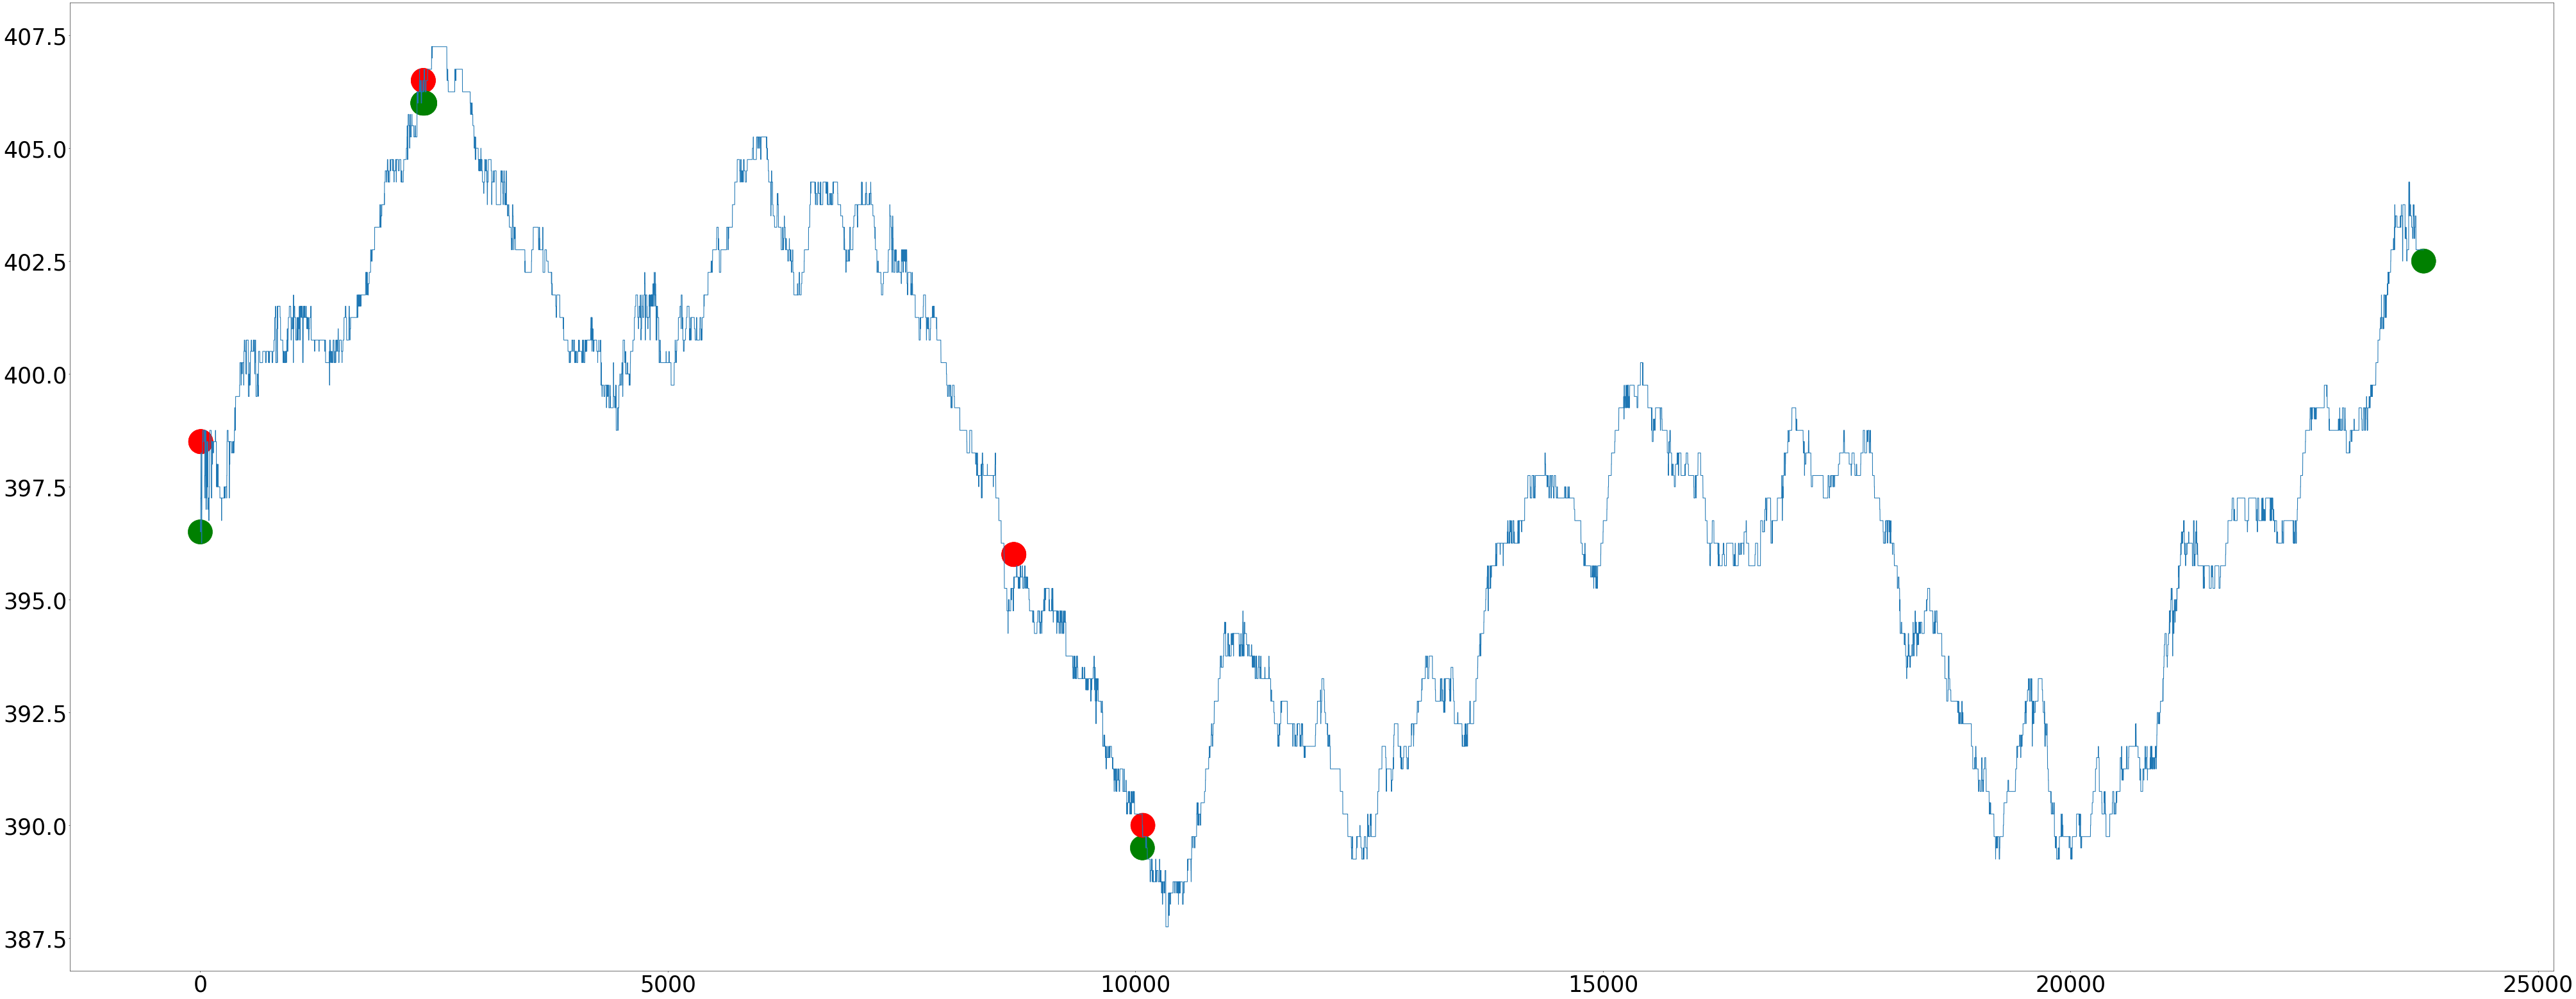

In [143]:
plt.figure(figsize=(100,40),dpi=50)
plt.plot(df_train[df_train.TxTime == '2020-03-25'].reset_index()['mid1'])
plt.scatter(tick, price, color = (side), s = 3000)
plt.yticks(fontsize=50)
plt.xticks(fontsize=50)

In [224]:
#setting parameters
import itertools 
long_side, short_side, stop_1 = [0.001, 0.0015], [-0.001, -0.0015], [-0.01, -0.015]
paras_2_3 = list(itertools.product(long_side, short_side, stop_1))
paras_2_3

[(0.001, -0.001, -0.01),
 (0.001, -0.001, -0.015),
 (0.001, -0.0015, -0.01),
 (0.001, -0.0015, -0.015),
 (0.0015, -0.001, -0.01),
 (0.0015, -0.001, -0.015),
 (0.0015, -0.0015, -0.01),
 (0.0015, -0.0015, -0.015)]

In [225]:
for i in paras_2_3:
    print(i)
    performance(equity_value_1[[i]], transaction_history1[i])

(0.001, -0.001, -0.01)
return: -0.14488585395950593
std: 0.054740023638123865
sharp ratio: -2.7417937367308363
trades: 63.0
odds ratio: 0.25396825396825395
mdd: 0.19921725286401817
skewness: -0.5499645571684785
(0.001, -0.001, -0.015)
return: -0.0900608922987393
std: 0.04072805203568992
sharp ratio: -2.338950368047614
trades: 51.0
odds ratio: 0.3333333333333333
mdd: 0.16000923091110614
skewness: -0.38993542348771215
(0.001, -0.0015, -0.01)
return: -0.09501841258289247
std: 0.052236060195583876
sharp ratio: -1.9185675988512836
trades: 59.0
odds ratio: 0.2542372881355932
mdd: 0.19260413044094488
skewness: -0.2220055694782666
(0.001, -0.0015, -0.015)
return: -0.020282736387831762
std: 0.04181182396109933
sharp ratio: -0.6094624432442904
trades: 47.0
odds ratio: 0.3617021276595745
mdd: 0.1389023712003416
skewness: -0.2802609751769144
(0.0015, -0.001, -0.01)
return: 0.027842628619985293
std: 0.02175851062270612
sharp ratio: 1.040633203835034
trades: 41.0
odds ratio: 0.2926829268292683
mdd: 

In [154]:
#test set
#profit_col = [(0.0015, -0.002, -0.015), (0.0015, -0.0015, -0.015), (0.0015, -0.0015, -0.01)]

In [247]:
#adding hard stop 
#main strategy (test set)
#record transaction
transaction_history2 = {}
#record equity values
equity_value_2 = pd.DataFrame()
#record each returns
each_return2 = pd.DataFrame()
#record unrealized gain
unrealized_2 = pd.DataFrame()
for l in range(len(profit_col)):
    df_test['side'] = pd.DataFrame(data = np.zeros((len(df_test), 1)), index = df_test.index[:])
    for j in range(len(df_test)):
        if df_test['pred_return'].iloc[j] > profit_col[l][0]:
            #long side
            df_test['side'].iloc[j] = 1
        elif df_test['pred_return'].iloc[j] < profit_col[l][1]:
            #short side
            df_test['side'].iloc[j] = -1
    date_idx = df_test['TxTime'].unique()
    #紀錄已實現
    equity_value2 = pd.DataFrame()
    #紀錄未實現
    unrealized2 = pd.DataFrame()
    for k in date_idx:
        df = df_test[df_test.TxTime == k]
        #side = 0
        for i in range(len(df)):
            #first tick
            if i == 0:
                df['holding'].iloc[i] = 0
                #ask1 may be 0, which means 漲停 (買不到)
                if (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] != 0):
                    #side = 1
                    df['holding'].iloc[i] = 1
                    #stock_price = df['Ask1'].iloc[i]
                    df['equity_value'].iloc[i] = 0
                    transaction_history2 = record_transaction(profit_col[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history2)
                elif (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] == 0):
                    side = 0
                    df['equity_value'].iloc[i] = 0
                elif df['side'].iloc[i] == -1:
                    #side = -1
                    df['holding'].iloc[i] = -1
                    #stock_price = df['Bid1'].iloc[i]
                    df['equity_value'].iloc[i] = - 0.0015
                    df['unrealized'].iloc[i] = -0.0015
                    transaction_history2 = record_transaction(profit_col[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history2)
                else:
                    #side = 0
                    df['holding'].iloc[i] = 0
                    df['equity_value'].iloc[i] = 0
            #last tick
            elif i == (len(df) - 1):
                if df['holding'].iloc[i-1] == 1:
                    df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history2[profit_col[l]][-1]['Price'] - 1) - 0.0015
                    df['unrealized'].iloc[i] = 'realized'
                    #df['unrealized'].iloc[i] = df['Bid1'].iloc[i] / df['mid1'].iloc[i-1] - 1
                    transaction_history2 = record_transaction(profit_col[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i], transaction_history2)
                #ask1 may be 0, which means 漲停 (買不到)
                elif (df['holding'].iloc[i-1] == -1) and (df['Ask1'].iloc[i] != 0):
                    df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history2[profit_col[l]][-1]['Price'] - 1) * (-1)
                    df['unrealized'].iloc[i] = 'realized'
                    #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                    transaction_history2 = record_transaction(profit_col[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history2)
                #收盤如果漲停，空單結不掉，先用mid1結
                elif (df['holding'].iloc[i-1] == -1) and (df['Ask1'].iloc[i] == 0):
                    df['equity_value'].iloc[i] = (df['mid1'].iloc[i] / transaction_history2[profit_col[l]][-1]['Price'] - 1) * (-1)
                    df['unrealized'].iloc[i] = 'realized'
                    #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                    transaction_history2 = record_transaction(profit_col[l], k, i, 1, df['mid1'].iloc[i], df['equity_value'].iloc[i], transaction_history2)
                else:
                    df['equity_value'].iloc[i] = 0
            else:
                if df['holding'].iloc[i-1] == 1:
                    #hard stop 1 -1 = 0 -> 0
                    if ((df['mid1'].iloc[i-1] / transaction_history2[profit_col[l]][-1]['Price'] - 1) < profit_col[l][2]): #or ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) > paras[l][2]):
                        df['holding'].iloc[i] = 0
                        df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history2[profit_col[l]][-1]['Price'] - 1) - 0.0015
                        df['unrealized'].iloc[i] = 'realized'
                        #df['unrealized'].iloc[i] = df['Bid1'].iloc[i] / df['mid1'].iloc[i-1] - 1
                        transaction_history2 = record_transaction(profit_col[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i], transaction_history2)
                    #change side 1 -2 -> -1
                    elif (df['side'].iloc[i] == -1): #and ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) > 0.01):
                        df['holding'].iloc[i] = -1
                        df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history2[profit_col[l]][-1]['Price'] - 1) - (0.0015 * 2)
                        df['unrealized'].iloc[i] = 'realized'
                        transaction_history2 = record_transaction(profit_col[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i] + 0.0015, transaction_history2)
                        transaction_history2 = record_transaction(profit_col[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history2)
                    else:
                        df['holding'].iloc[i] = df['holding'].iloc[i-1]
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1)
                elif df['holding'].iloc[i-1] == -1:
                    #hard stop -1 +1 -> 0
                    if (df['Ask1'].iloc[i] != 0) and ((df['mid1'].iloc[i-1] / transaction_history2[profit_col[l]][-1]['Price'] - 1) * (-1) < profit_col[l][2]): #or ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1) > paras[l][2])):
                        df['holding'].iloc[i] = 0
                        df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history2[profit_col[l]][-1]['Price'] - 1) * (-1)
                        df['unrealized'].iloc[i] = 'realized'
                        #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                        transaction_history2 = record_transaction(profit_col[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history2)
                    #change side -1 +2 -> 1
                    elif (df['Ask1'].iloc[i] != 0) and (df['side'].iloc[i] == 1): #and ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1) > 0.01):
                        df['holding'].iloc[i] = 1
                        df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history2[profit_col[l]][-1]['Price'] - 1) * (-1)
                        df['unrealized'].iloc[i] = 'realized'
                        #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                        transaction_history2 = record_transaction(profit_col[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history2)
                        transaction_history2 = record_transaction(profit_col[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history2)
                    else:
                        df['holding'].iloc[i] = df['holding'].iloc[i-1]
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                elif df['holding'].iloc[i-1] == 0:
                    if (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] != 0):
                        df['holding'].iloc[i] = 1
                        df['equity_value'].iloc[i] = 0
                        transaction_history2 = record_transaction(profit_col[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history2)
                    elif df['side'].iloc[i] == -1:
                        df['holding'].iloc[i] = -1
                        df['equity_value'].iloc[i] = - 0.0015
                        df['unrealized'].iloc[i] = -0.0015
                        transaction_history2 = record_transaction(profit_col[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history2)
                    else:
                        df['holding'].iloc[i] = 0
                        df['equity_value'].iloc[i] = 0
        equity_value2 = pd.concat([equity_value2, df[['equity_value']]])
        unrealized2 = pd.concat([unrealized2, df['unrealized']])
    #concat
    equity_value_2 = pd.concat([equity_value_2, np.cumsum(equity_value2)], axis = 1)
    each_return2 = pd.concat([each_return2, equity_value2], axis = 1)
    unrealized_2 = pd.concat([unrealized_2, unrealized2], axis = 1)

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\U

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [248]:
equity_value_2.columns = profit_col
equity_value_2

,"(0.001, -0.0015, -0.025)","(0.001, -0.002, -0.025)","(0.001, -0.0025, -0.015)","(0.001, -0.0025, -0.02)","(0.001, -0.0025, -0.025)","(0.0015, -0.001, -0.01)","(0.0015, -0.001, -0.015)","(0.0015, -0.001, -0.02)","(0.0015, -0.0015, -0.01)","(0.0015, -0.002, -0.01)"
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
121180,0.015628,0.015628,0.006228,0.019818,0.019701,-0.028950,-0.002650,0.009778,-0.021275,-0.021275
121181,0.015628,0.015628,0.006228,0.019818,0.019701,-0.028950,-0.002650,0.009778,-0.021275,-0.021275
121182,0.015628,0.015628,0.006228,0.019818,0.019701,-0.028950,-0.002650,0.009778,-0.021275,-0.021275
121183,0.015628,0.015628,0.006228,0.019818,0.019701,-0.028950,-0.002650,0.009778,-0.021275,-0.021275


In [249]:
for i in equity_value_2.iloc[-1].sort_values(ascending=False).index.to_list():
    print(i)
    performance(equity_value_2[[i]], transaction_history2[i])

(0.001, -0.0025, -0.025)
return: 0.01605752288924983
std: 0.02579792057686661
sharp ratio: 0.42086814155811997
trades: 11.0
odds ratio: 0.45454545454545453
mdd: 0.03850070200093014
skewness: 0.6649502140199656
(0.001, -0.002, -0.025)
return: 0.01412773765090686
std: 0.02509074448105724
sharp ratio: 0.35581796537153504
trades: 13.0
odds ratio: 0.38461538461538464
mdd: 0.03850070200093014
skewness: 0.6331946806196549
(0.001, -0.0015, -0.025)
return: 0.01412773765090686
std: 0.02509074448105724
sharp ratio: 0.35581796537153504
trades: 13.0
odds ratio: 0.38461538461538464
mdd: 0.03850070200093014
skewness: 0.6331946806196549
(0.001, -0.0025, -0.02)
return: 0.011914674518908376
std: 0.02507692610103718
sharp ratio: 0.2677630620218105
trades: 12.0
odds ratio: 0.4166666666666667
mdd: 0.0436138834619359
skewness: 0.5843771118866337
(0.001, -0.0025, -0.015)
return: 0.007960327374630706
std: 0.025888973215537618
sharp ratio: 0.10662174013815498
trades: 14.0
odds ratio: 0.5
mdd: 0.042613578119648

In [250]:
transaction_history2[(0.001, -0.0025, -0.025)]

[{'Date': '2020-04-23',
  'tick': 5,
  'Action': 1,
  'Price': 448.0,
  'Equity_value': 0},
 {'Date': '2020-04-23',
  'tick': 8484,
  'Action': -1,
  'Price': 436.5,
  'Equity_value': -0.027169642857142906},
 {'Date': '2020-04-23',
  'tick': 8490,
  'Action': 1,
  'Price': 437.5,
  'Equity_value': 0},
 {'Date': '2020-04-23',
  'tick': 14534,
  'Action': -1,
  'Price': 443.5,
  'Equity_value': 0.01221428571428579},
 {'Date': '2020-04-24',
  'tick': 5,
  'Action': 1,
  'Price': 438.0,
  'Equity_value': 0},
 {'Date': '2020-04-24',
  'tick': 13517,
  'Action': -1,
  'Price': 429.5,
  'Equity_value': -0.02090639269406397},
 {'Date': '2020-04-27',
  'tick': 7,
  'Action': -1,
  'Price': 439.0,
  'Equity_value': -0.0015},
 {'Date': '2020-04-27',
  'tick': 12,
  'Action': 1,
  'Price': 439.5,
  'Equity_value': -0.001138952164009055},
 {'Date': '2020-04-27',
  'tick': 12,
  'Action': 1,
  'Price': 439.5,
  'Equity_value': 0},
 {'Date': '2020-04-27',
  'tick': 14432,
  'Action': -1,
  'Price': 4

In [221]:
tick = []
side = []
price = []
for i in range(len(transaction_history2[(0.001, -0.0025, -0.015)])):
    if transaction_history2[(0.001, -0.0025, -0.015)][i]['Date'] == '2020-05-04':
        tick.append(transaction_history2[(0.001, -0.0025, -0.015)][i]['tick'])
        price.append(transaction_history2[(0.001, -0.0025, -0.015)][i]['Price'])
        if transaction_history2[(0.001, -0.0025, -0.015)][i]['Action'] == 1:
            side.append('red')
        else:
            side.append('green')

In [203]:
tick

[2, 7026, 7152, 9863, 9872, 14216]

In [204]:
side

['red', 'green', 'red', 'green', 'red', 'green']

(array([-2000.,     0.,  2000.,  4000.,  6000.,  8000., 10000., 12000.,
        14000., 16000.]),
 <a list of 10 Text xticklabel objects>)

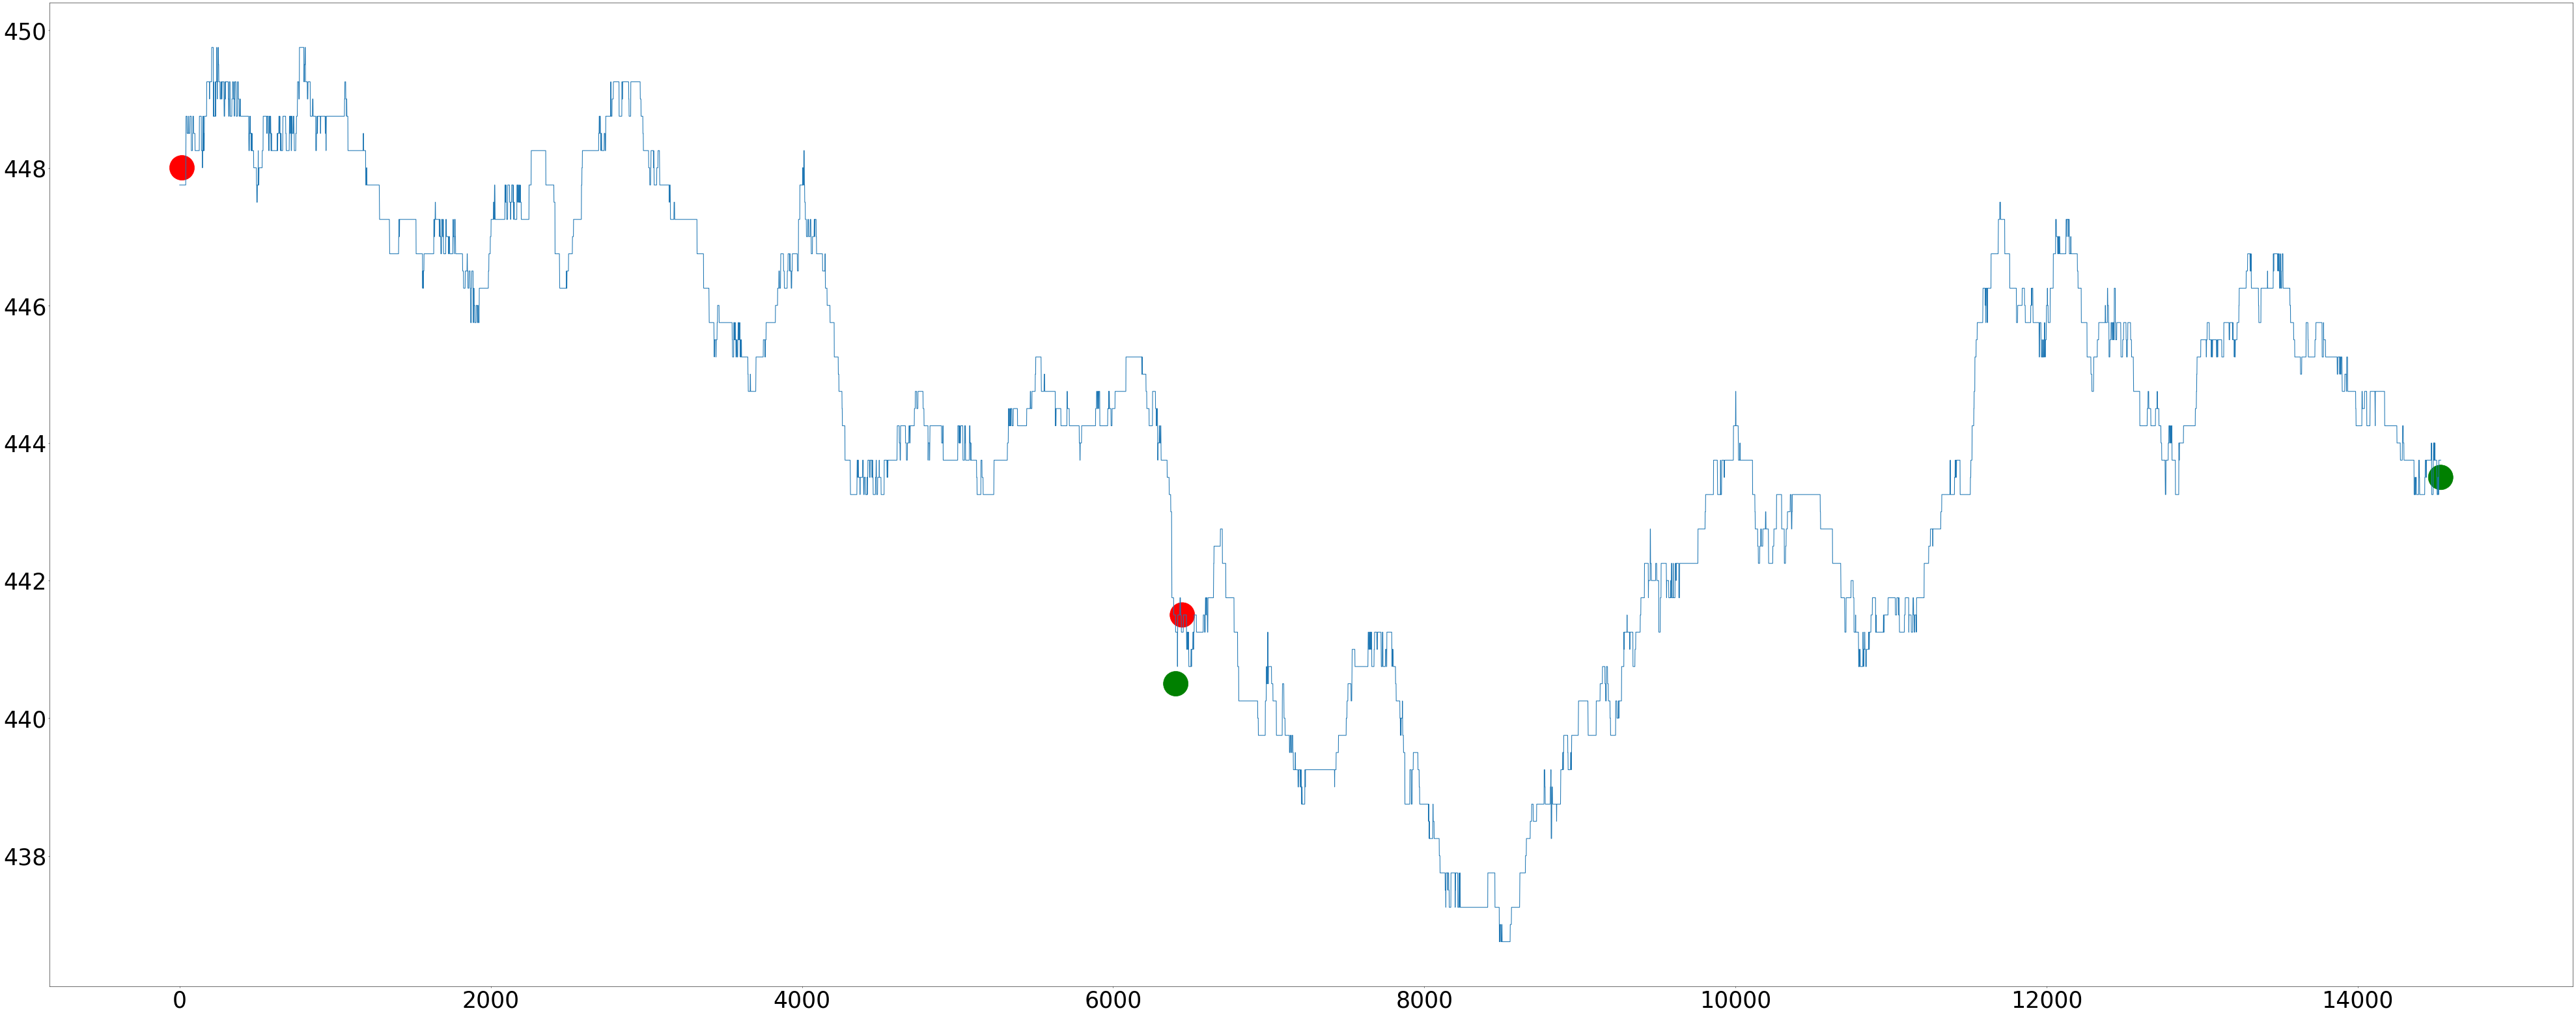

In [180]:
plt.figure(figsize=(100,40),dpi=50)
plt.plot(df_test[df_test.TxTime == '2020-04-23'].reset_index()['mid1'])
plt.scatter(tick, price, color = (side), s = 3000)
plt.yticks(fontsize=50)
plt.xticks(fontsize=50)

(array([-2000.,     0.,  2000.,  4000.,  6000.,  8000., 10000., 12000.,
        14000., 16000.]),
 <a list of 10 Text xticklabel objects>)

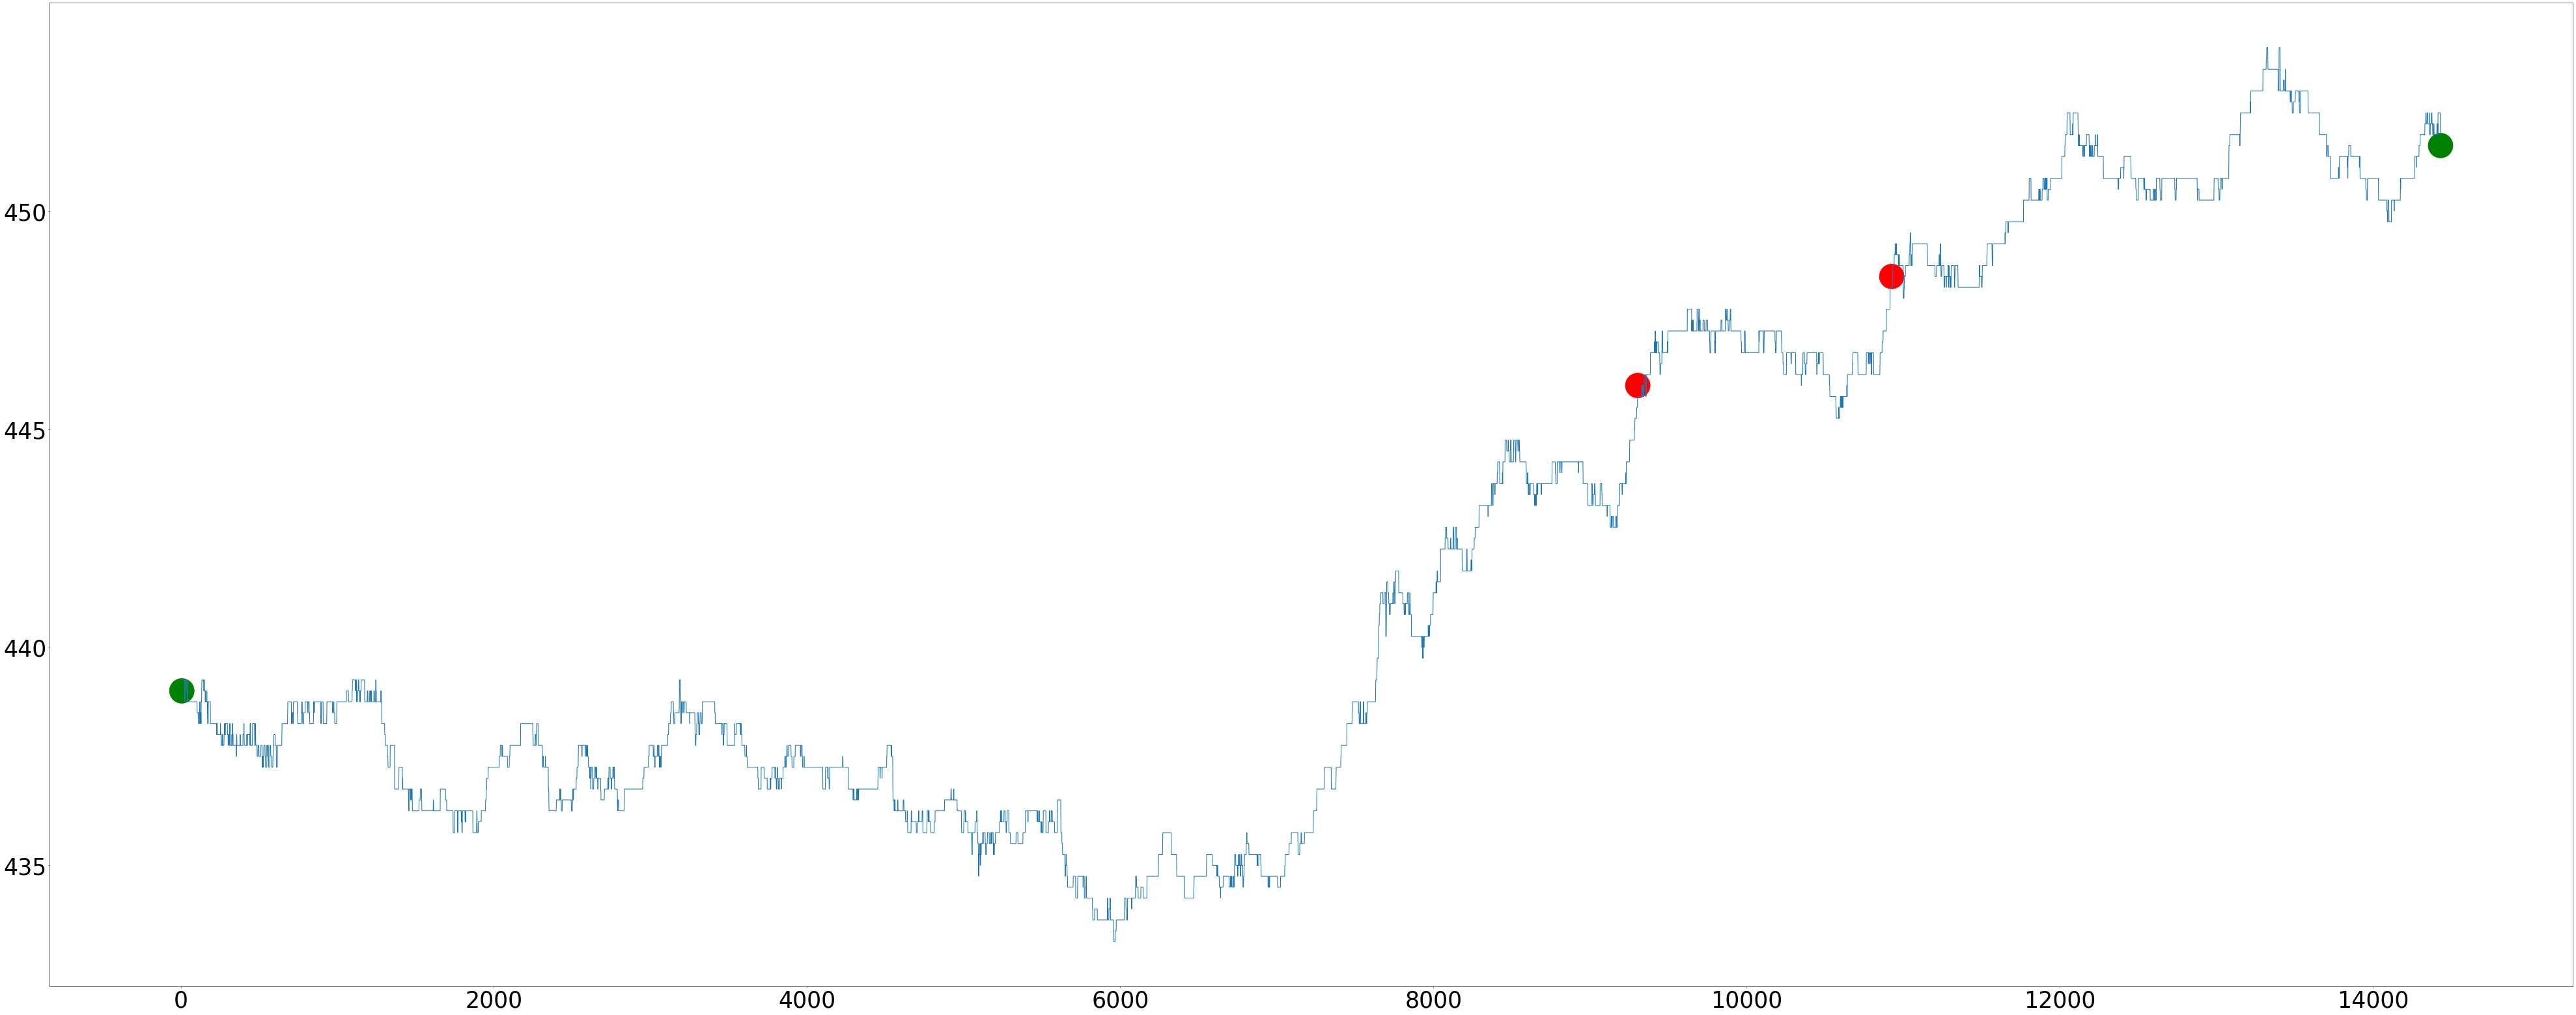

In [184]:
plt.figure(figsize=(100,40),dpi=50)
plt.plot(df_test[df_test.TxTime == '2020-04-27'].reset_index()['mid1'])
plt.scatter(tick, price, color = (side), s = 3000)
plt.yticks(fontsize=50)
plt.xticks(fontsize=50)

(array([-2000.,     0.,  2000.,  4000.,  6000.,  8000., 10000., 12000.,
        14000., 16000.]),
 <a list of 10 Text xticklabel objects>)

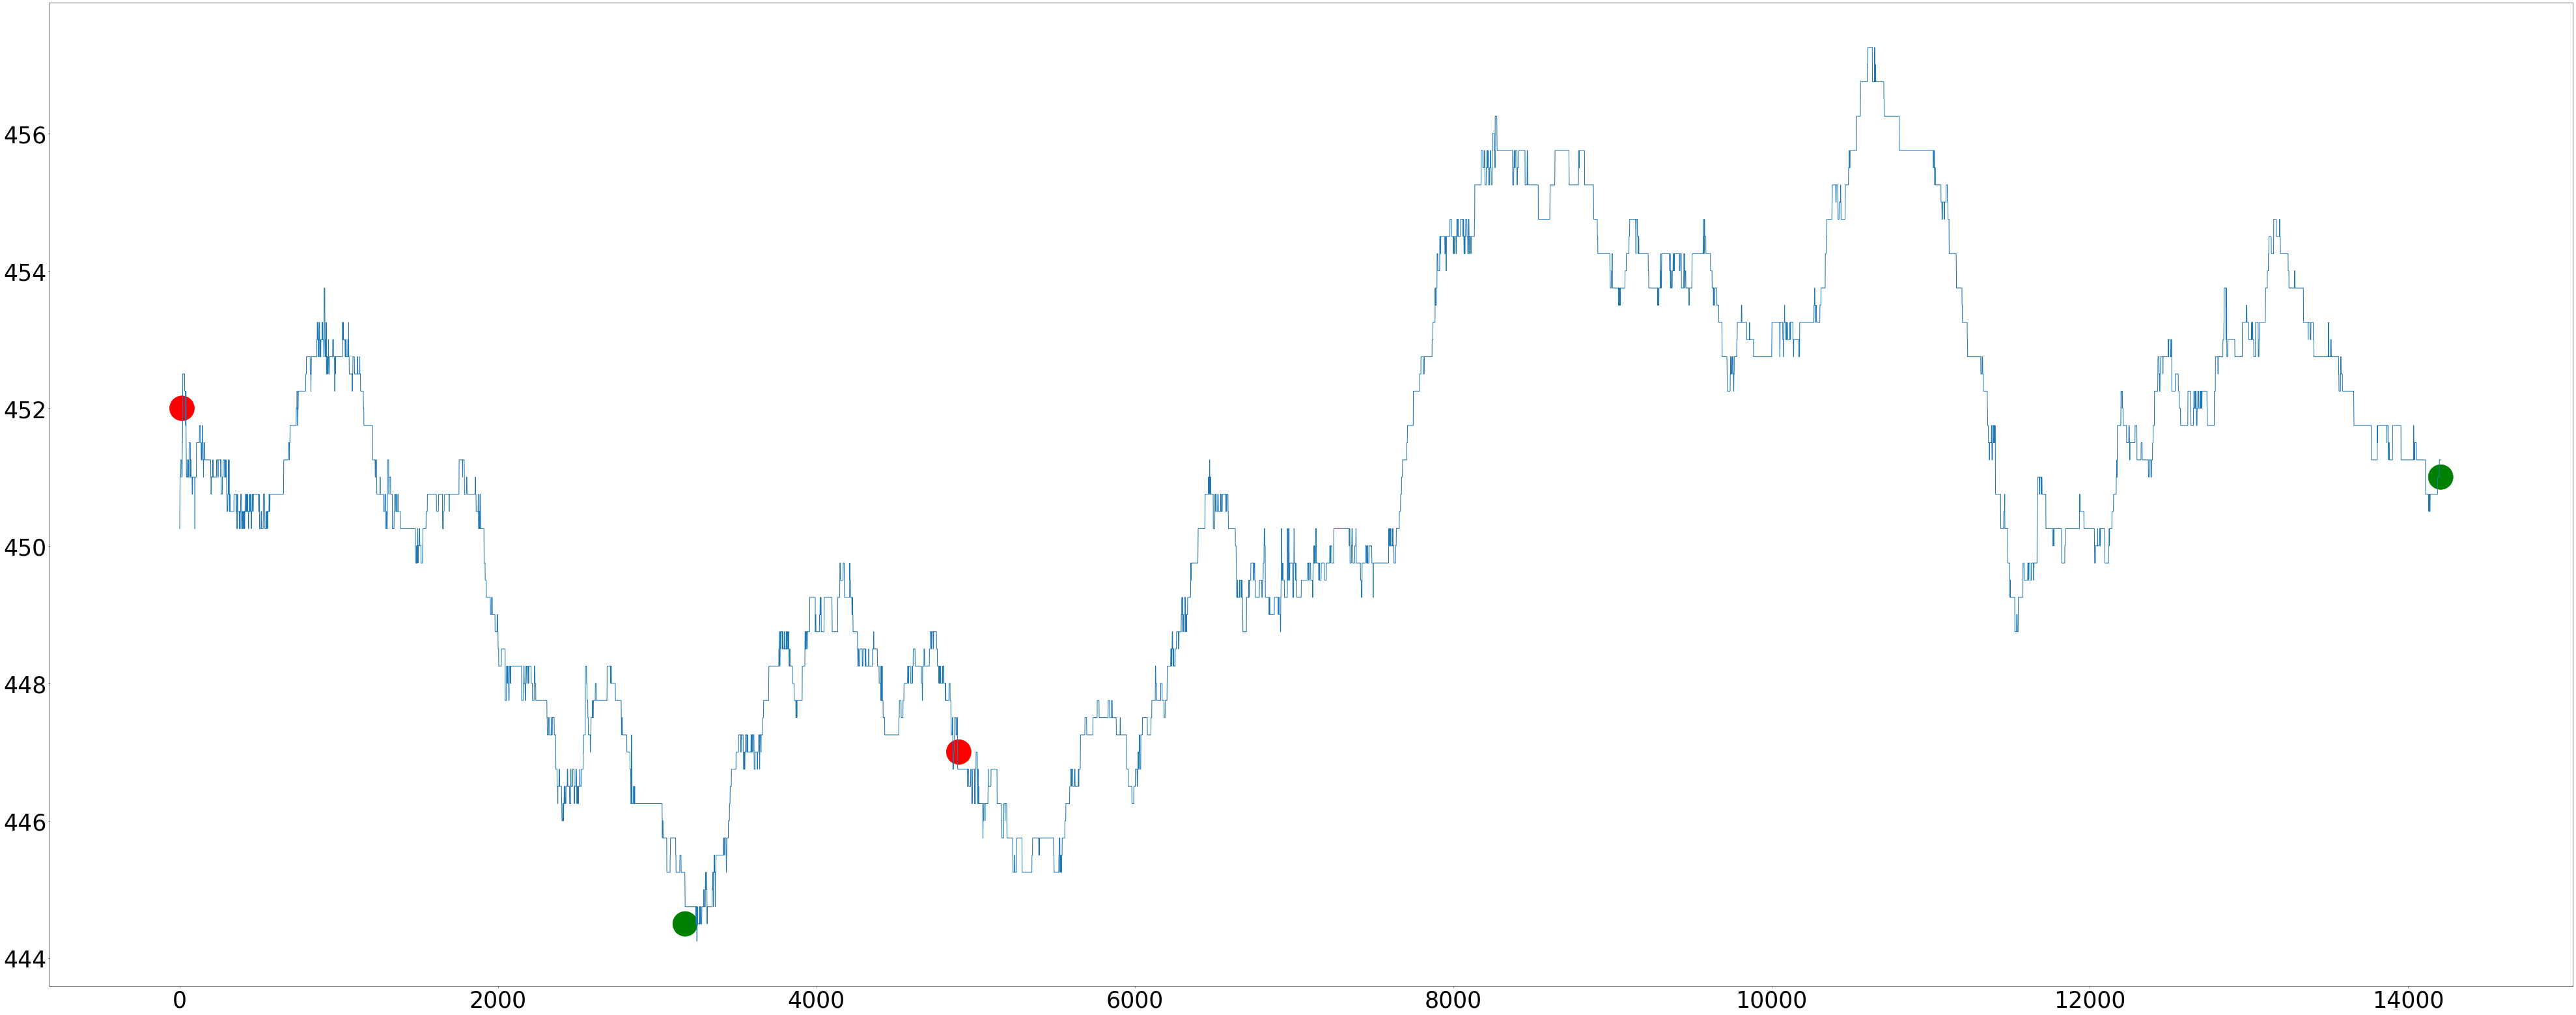

In [188]:
plt.figure(figsize=(100,40),dpi=50)
plt.plot(df_test[df_test.TxTime == '2020-04-28'].reset_index()['mid1'])
plt.scatter(tick, price, color = (side), s = 3000)
plt.yticks(fontsize=50)
plt.xticks(fontsize=50)

(array([-2000.,     0.,  2000.,  4000.,  6000.,  8000., 10000., 12000.,
        14000., 16000.]),
 <a list of 10 Text xticklabel objects>)

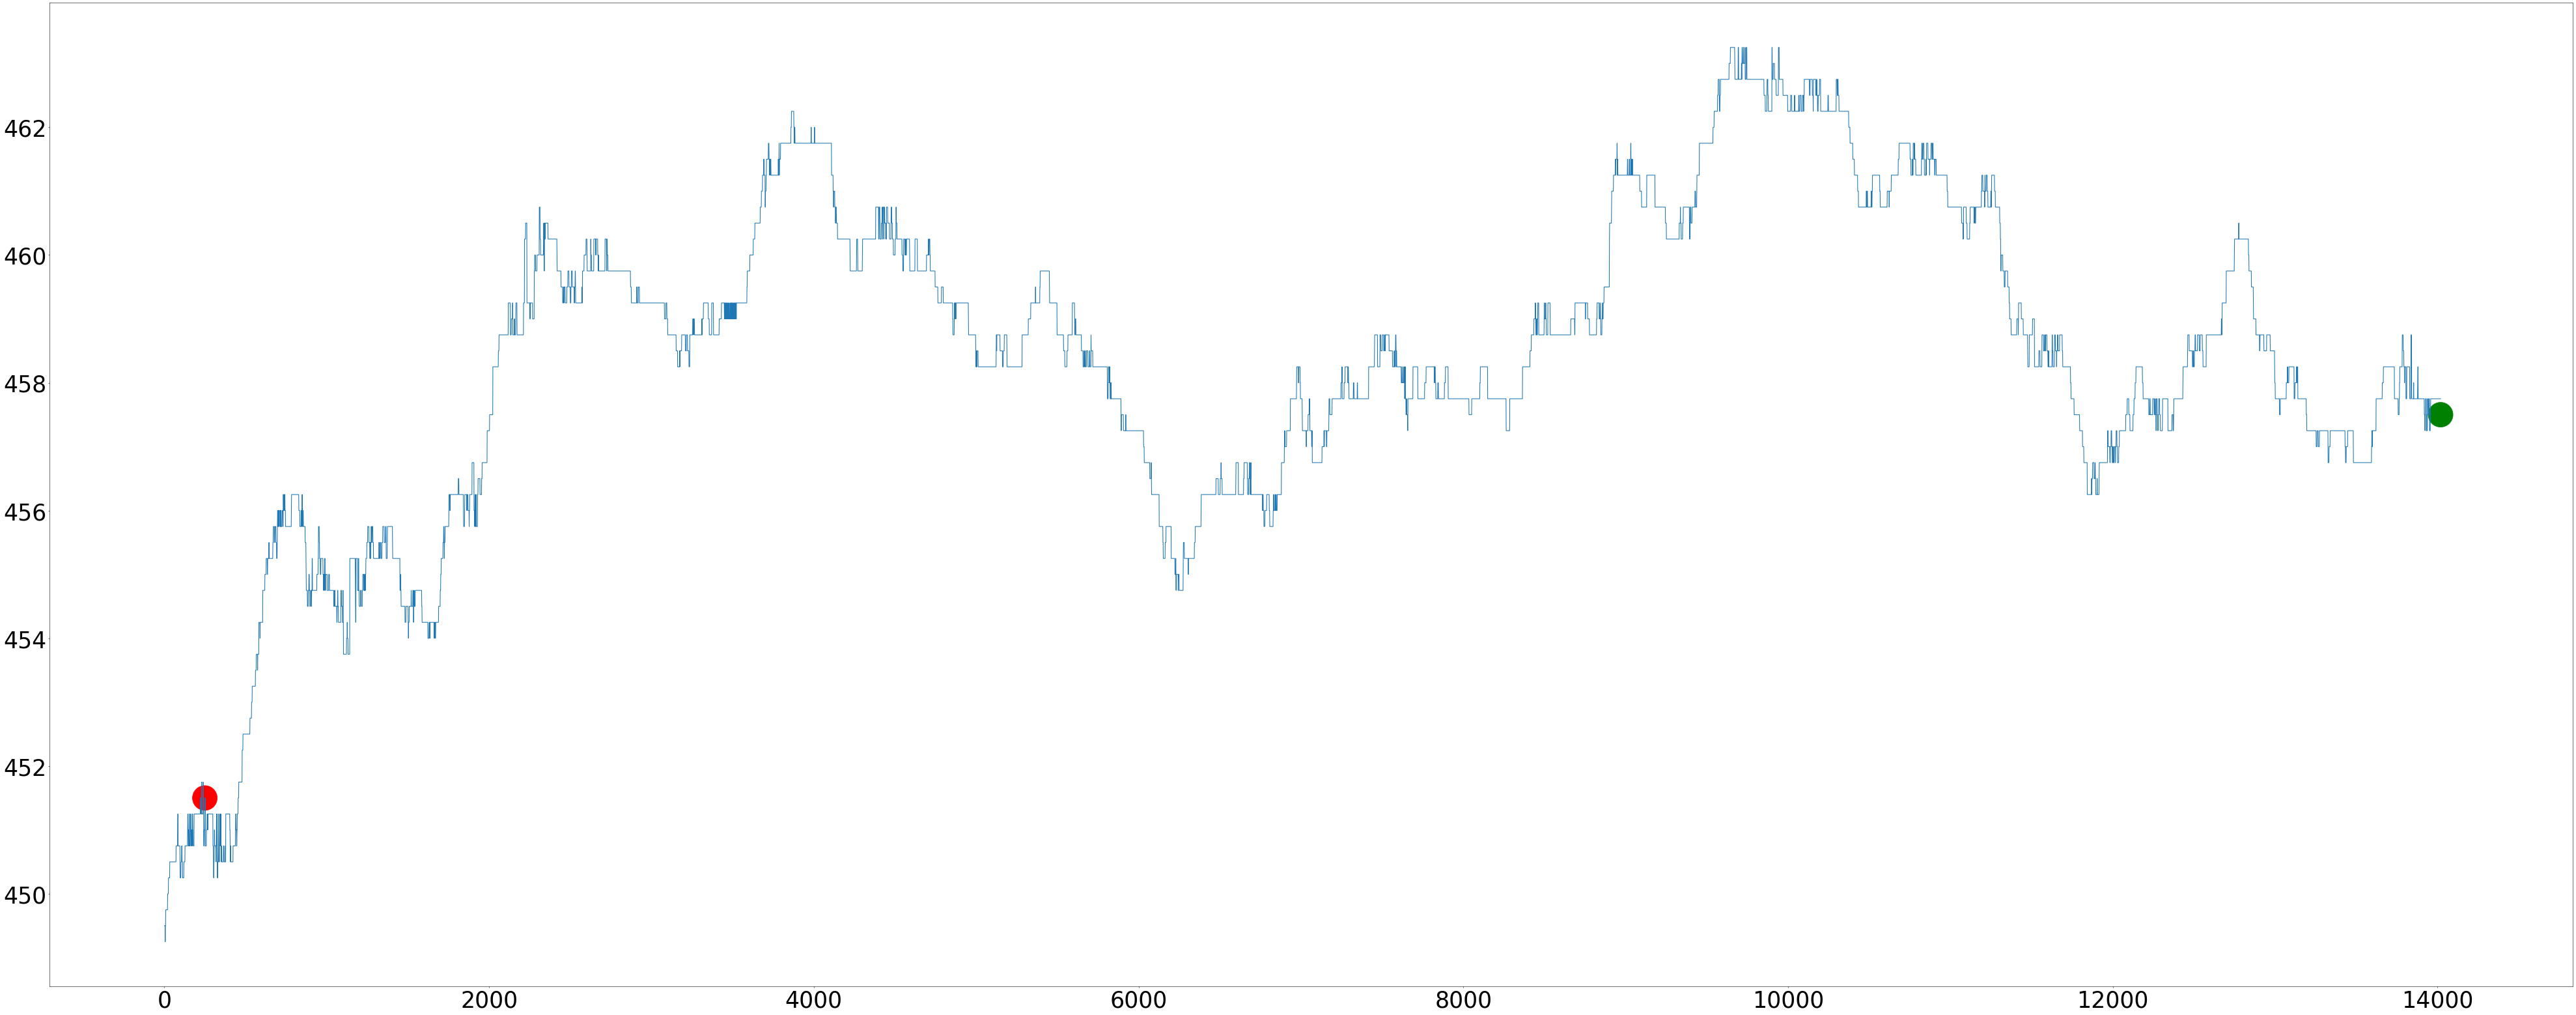

In [193]:
plt.figure(figsize=(100,40),dpi=50)
plt.plot(df_test[df_test.TxTime == '2020-04-29'].reset_index()['mid1'])
plt.scatter(tick, price, color = (side), s = 3000)
plt.yticks(fontsize=50)
plt.xticks(fontsize=50)

(array([-5000.,     0.,  5000., 10000., 15000., 20000., 25000.]),
 <a list of 7 Text xticklabel objects>)

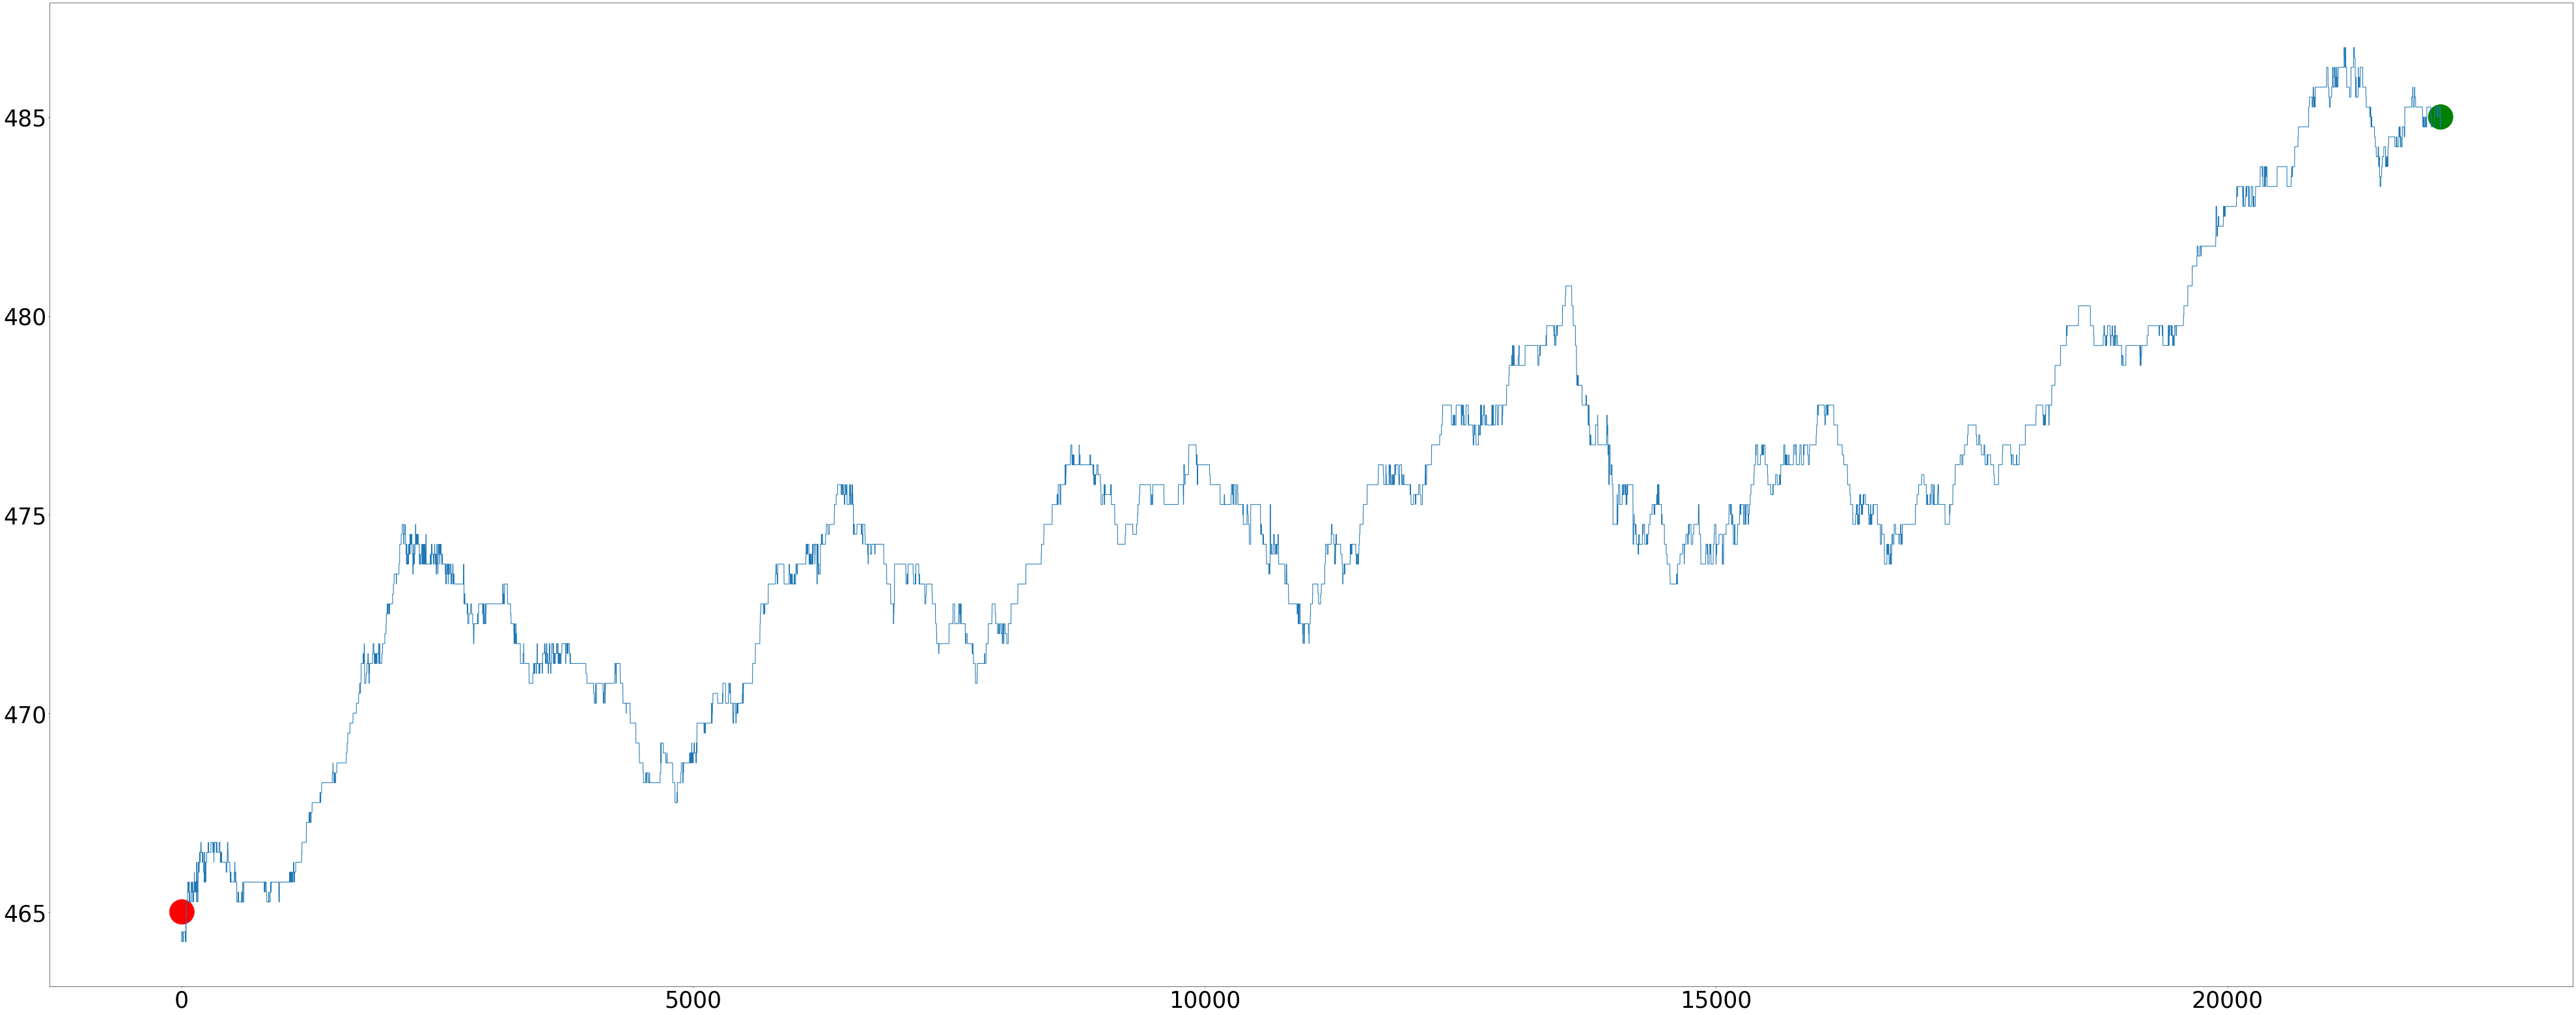

In [197]:
plt.figure(figsize=(100,40),dpi=50)
plt.plot(df_test[df_test.TxTime == '2020-04-30'].reset_index()['mid1'])
plt.scatter(tick, price, color = (side), s = 3000)
plt.yticks(fontsize=50)
plt.xticks(fontsize=50)

(array([-2000.,     0.,  2000.,  4000.,  6000.,  8000., 10000., 12000.,
        14000., 16000.]),
 <a list of 10 Text xticklabel objects>)

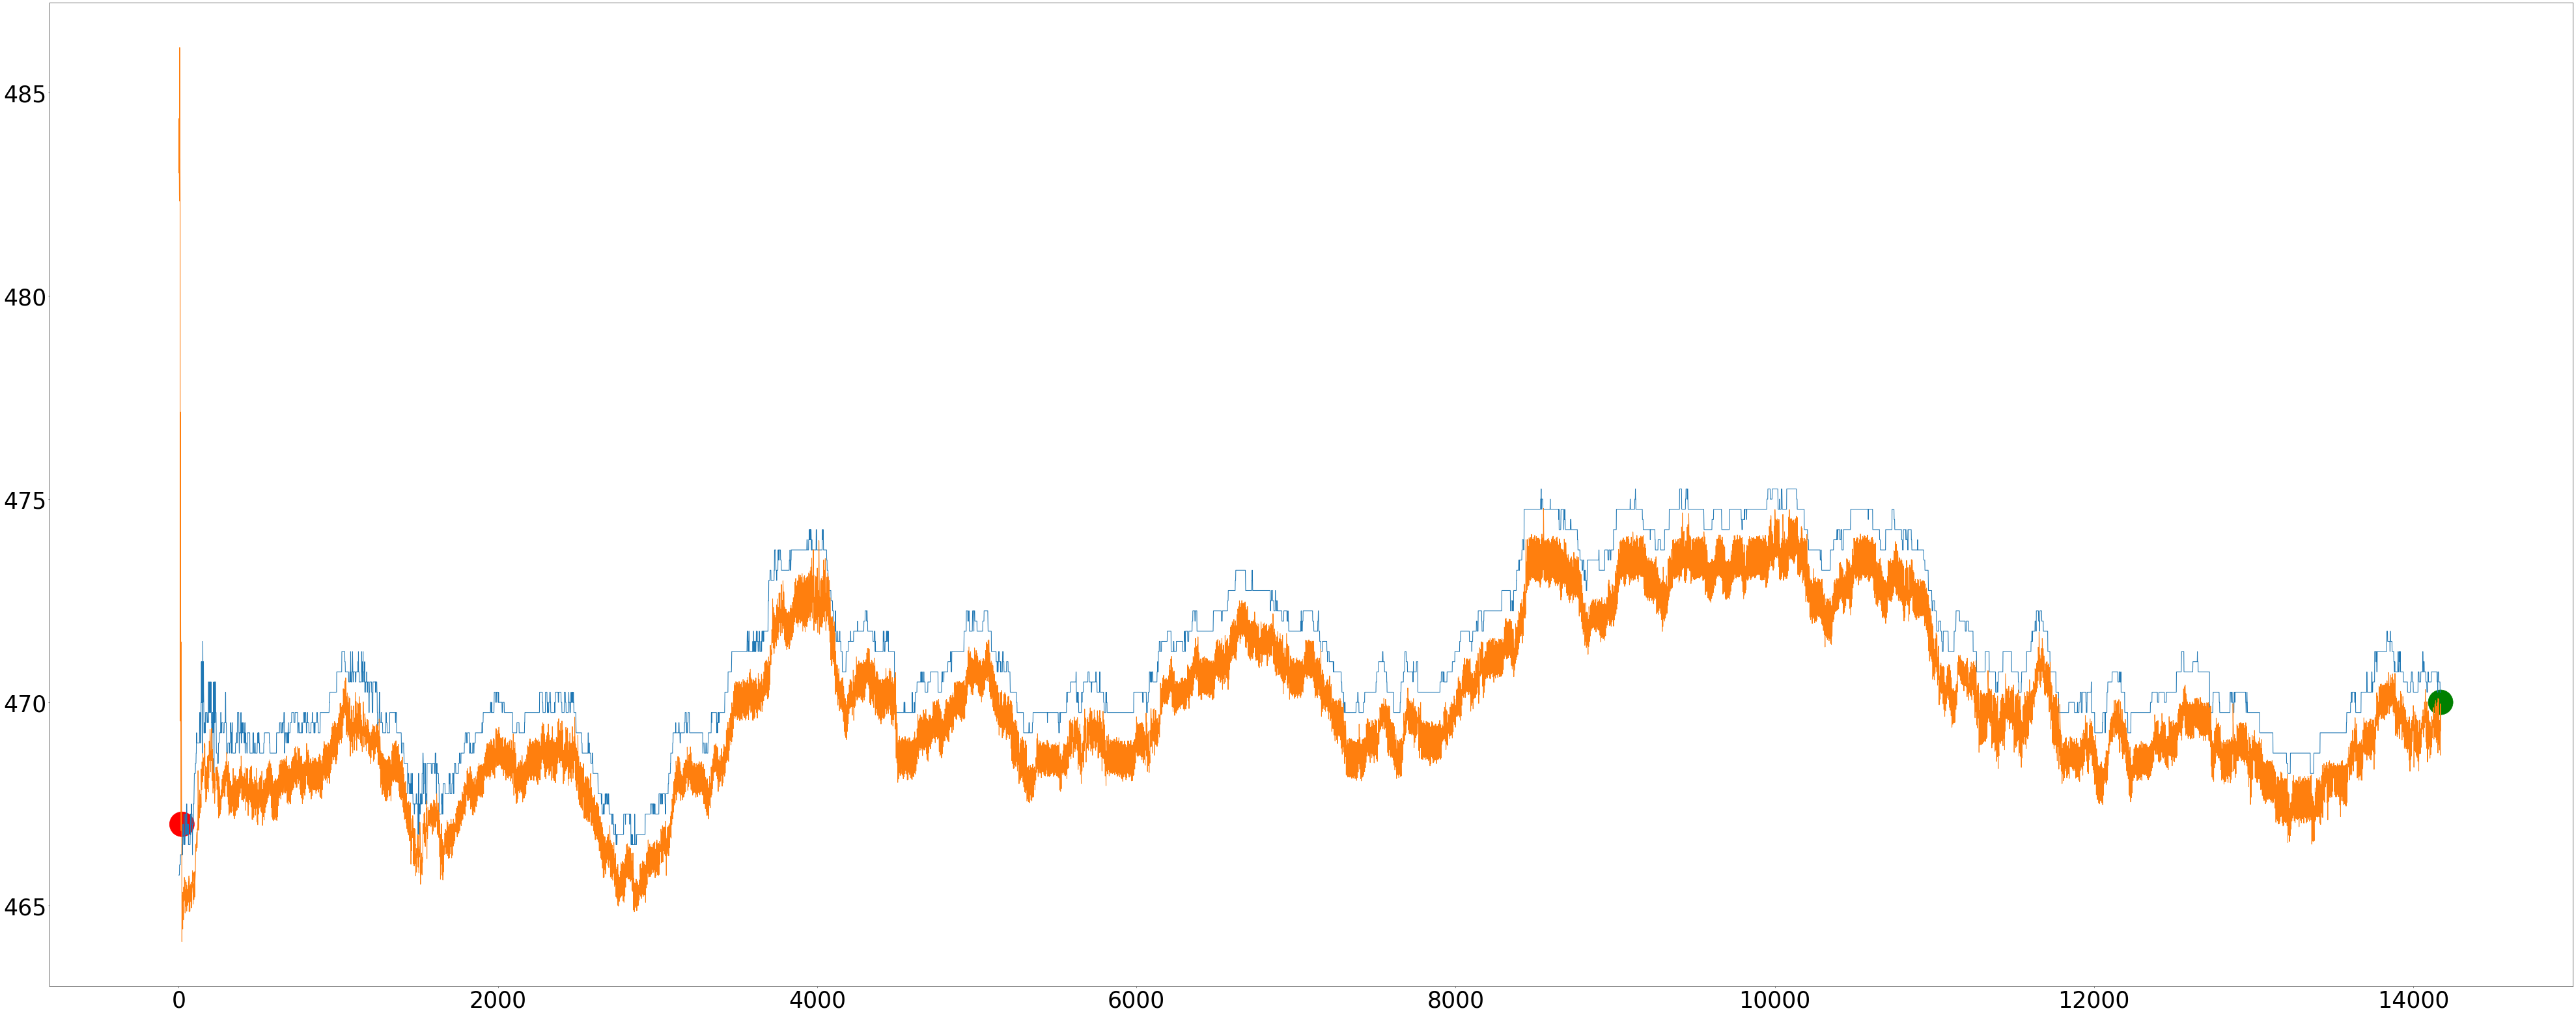

In [222]:
plt.figure(figsize=(100,40),dpi=50)
plt.plot(df_test[df_test.TxTime == '2020-05-04'].reset_index()['mid1'])
plt.plot(df_test[df_test.TxTime == '2020-05-04'].reset_index()['pred_mid'])
plt.scatter(tick, price, color = (side), s = 3000)
plt.yticks(fontsize=50)
plt.xticks(fontsize=50)

In [218]:
(df_test[df_test.TxTime == '2020-05-04']['pred_return'].iloc[2000:6000] < -0.0015).sum()

0

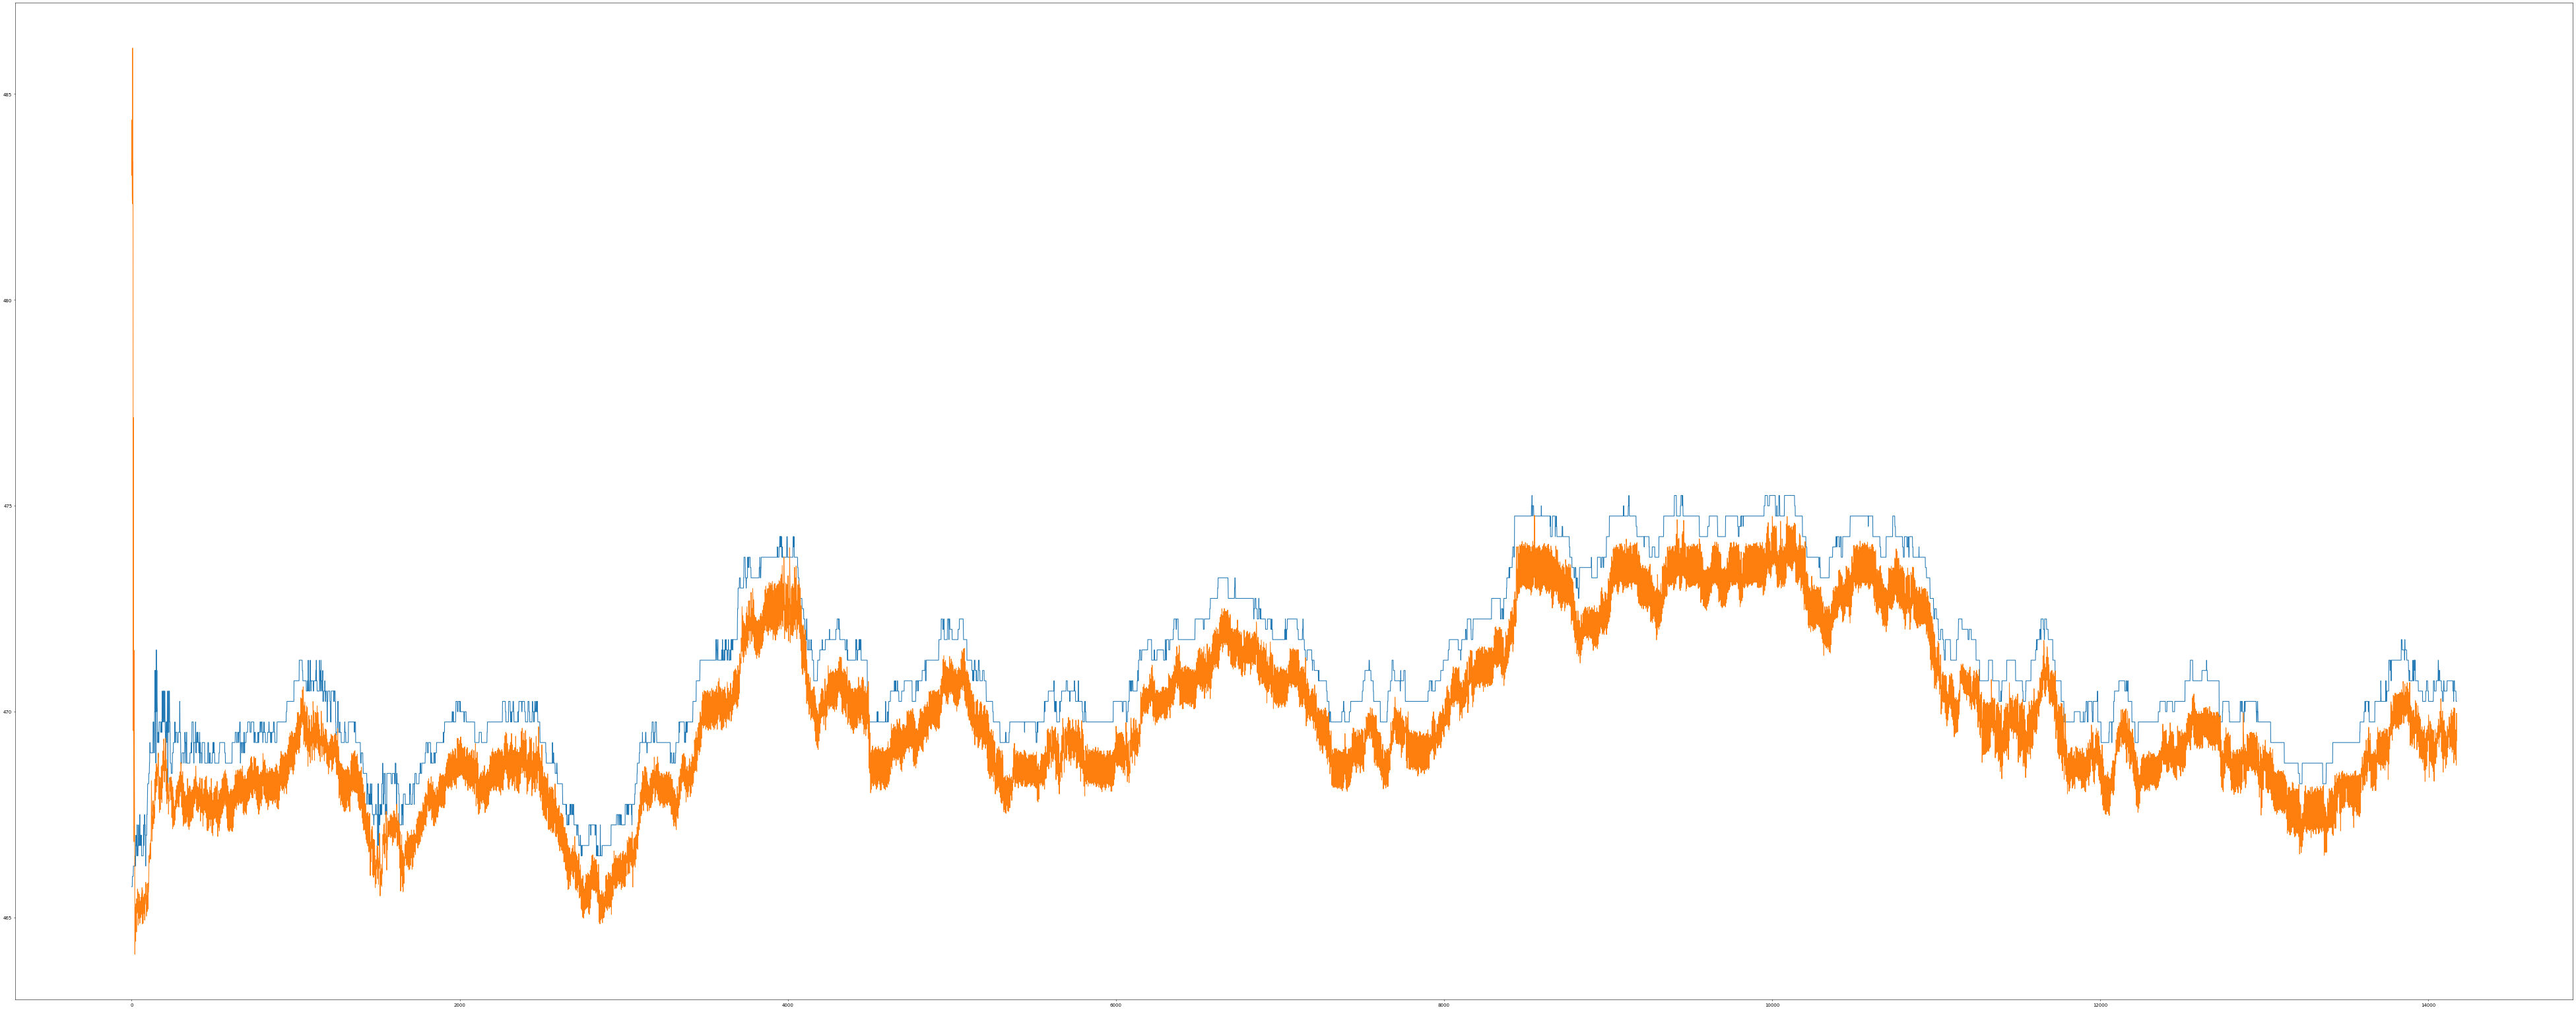

In [214]:
plt.figure(figsize=(100,40),dpi=50)
plt.plot(df_test[df_test.TxTime == '2020-05-04'].reset_index()['mid1'])
plt.plot(df_test[df_test.TxTime == '2020-05-04'].reset_index()['pred_mid'])

(array([-2000.,     0.,  2000.,  4000.,  6000.,  8000., 10000., 12000.,
        14000., 16000.]),
 <a list of 10 Text xticklabel objects>)

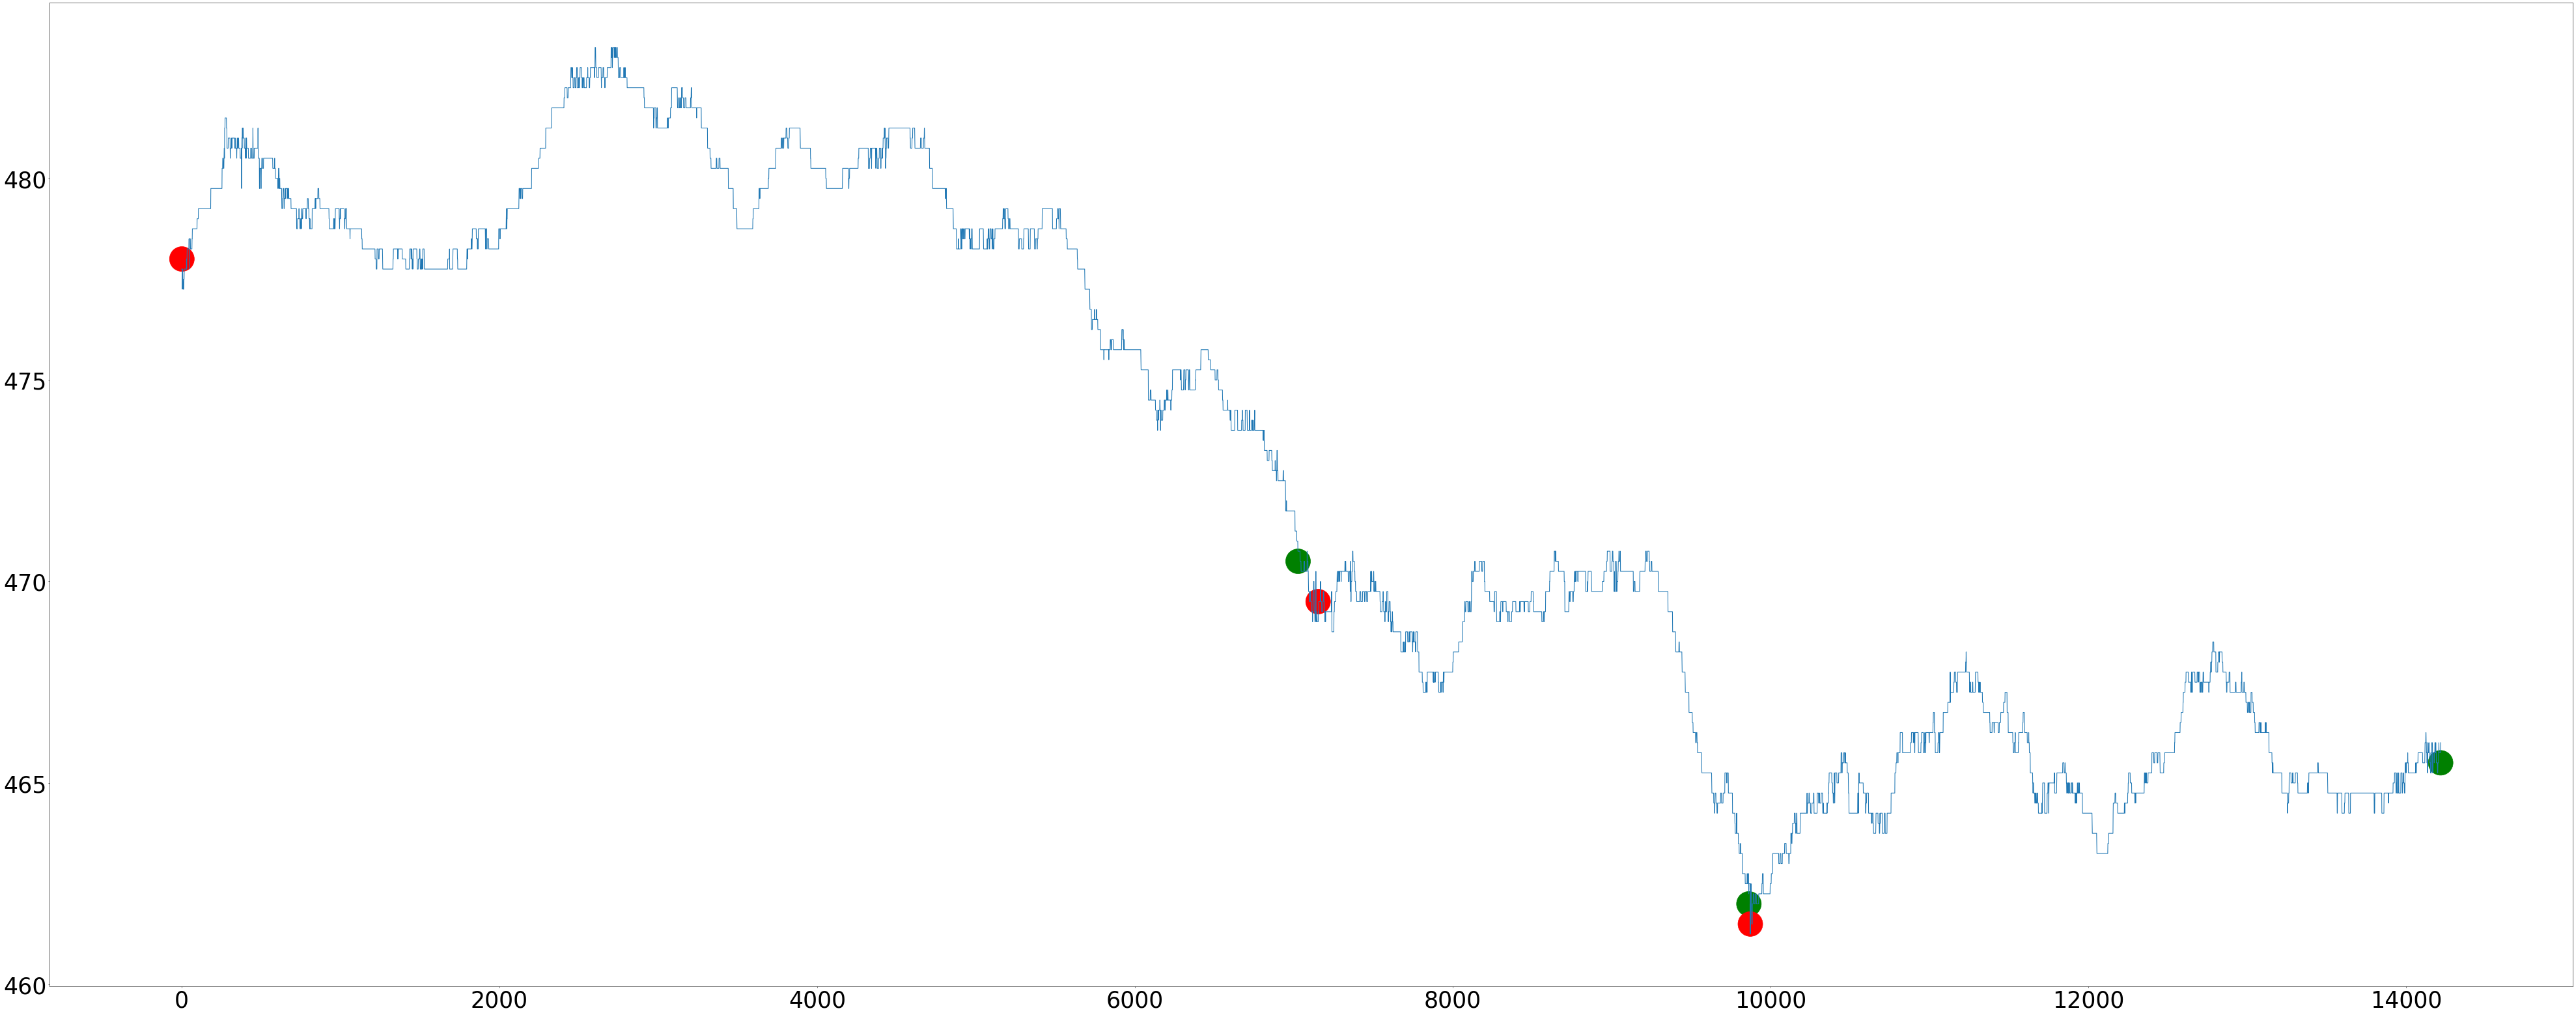

In [205]:
plt.figure(figsize=(100,40),dpi=50)
plt.plot(df_test[df_test.TxTime == '2020-05-05'].reset_index()['mid1'])
plt.scatter(tick, price, color = (side), s = 3000)
plt.yticks(fontsize=50)
plt.xticks(fontsize=50)

In [255]:
import itertools 
long_side, short_side, stop_1 = [0.001, 0.0015], [-0.001, -0.0015], [-0.01, -0.015]
paras = list(itertools.product(long_side, short_side, stop_1))
paras

[(0.001, -0.001, -0.01),
 (0.001, -0.001, -0.015),
 (0.001, -0.0015, -0.01),
 (0.001, -0.0015, -0.015),
 (0.0015, -0.001, -0.01),
 (0.0015, -0.001, -0.015),
 (0.0015, -0.0015, -0.01),
 (0.0015, -0.0015, -0.015)]

In [256]:
for i in paras:
    print(i)
    performance(equity_value_1[[i]], transaction_history1[i])

(0.001, -0.001, -0.01)
return: -0.14488585395950593
std: 0.054740023638123865
sharp ratio: -2.7417937367308363
trades: 63.0
odds ratio: 0.25396825396825395
mdd: 0.19921725286401817
skewness: -0.5499645571684785
(0.001, -0.001, -0.015)
return: -0.0900608922987393
std: 0.04072805203568992
sharp ratio: -2.338950368047614
trades: 51.0
odds ratio: 0.3333333333333333
mdd: 0.16000923091110614
skewness: -0.38993542348771215
(0.001, -0.0015, -0.01)
return: -0.09501841258289247
std: 0.052236060195583876
sharp ratio: -1.9185675988512836
trades: 59.0
odds ratio: 0.2542372881355932
mdd: 0.19260413044094488
skewness: -0.2220055694782666
(0.001, -0.0015, -0.015)
return: -0.020282736387831762
std: 0.04181182396109933
sharp ratio: -0.6094624432442904
trades: 47.0
odds ratio: 0.3617021276595745
mdd: 0.1389023712003416
skewness: -0.2802609751769144
(0.0015, -0.001, -0.01)
return: 0.027842628619985293
std: 0.02175851062270612
sharp ratio: 1.040633203835034
trades: 41.0
odds ratio: 0.2926829268292683
mdd: 